### Imports

In [1]:
import itertools
from random import *
import numpy as np
from collections import defaultdict, Counter

from sklearn.preprocessing import MultiLabelBinarizer
import keras

import matplotlib.pyplot as plt
import statistics

Using TensorFlow backend.


### Quantum circuit classes and definitions

In [2]:
class PhysicalQubit:
#relatively simple, only holds location and if it has undergone an x or z error

    def __init__(self, row, col):
        self.Xvalue = 0
        self.Zvalue = 0
        self.locationRow = row
        self.locationCol = col

    def flip_value(self, gate_type):
        if gate_type == 'x' or gate_type == 'y':
            if self.Xvalue == 1:
                self.Xvalue = 0
            else:
                self.Xvalue = 1

        if gate_type == 'z' or gate_type == 'y':
            if self.Zvalue == 1:
                self.Zvalue = 0
            else:
                self.Zvalue = 1

    def clear(self):
        self.Xvalue = 0
        self.Zvalue = 0

    def return_Xvalue(self):
        return self.Xvalue

    def return_Zvalue(self):
        return self.Zvalue
    

class AncillaQubit:

    def __init__(self, type, name):
        self.AType = type
        self.qubits = []
        self.on = False
        self.name = name
        self.row = 0
        self.col = 0

    def add_qubit(self, new_qubit):
        self.qubits.append(new_qubit)

    def setLocation(self, row, col):
        self.row = row
        self.col = col

    def connected(self, phys_qubit):
        if phys_qubit in self.qubits:
            return True
        else:
            return False

    #returns the measurement based on the error observed on its physical qubits
    def measure(self):
        total = 0
        if self.AType == "x":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Xvalue() == self.qubits[1].return_Xvalue():
                    total = 1
                else:
                    total = -1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Xvalue() + self.qubits[1].return_Xvalue() + self.qubits[2].return_Xvalue() + self.qubits[3].return_Xvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1

        elif self.AType == "z":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Zvalue() == self.qubits[1].return_Zvalue():
                    total += 1
                else:
                    total -= 1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Zvalue() + self.qubits[1].return_Zvalue() + self.qubits[2].return_Zvalue() + self.qubits[3].return_Zvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1
        return total
    
    
class ToricCircuit:

    def __init__(self, depth):
        self.depth = depth
        # initialize qubits to zero
        self.qubits = {}
        self.ancilla = []
        self.ancilla_matrix = [[1]*depth for _ in range(depth+1)]
        self.error_qubits_x = []
        self.error_qubits_z = []
        self.measurement_errs = {}
        for i in range(depth):
            for j in range(depth):
                qubit = PhysicalQubit(i, j)
                self.qubits.update({str(i) + str(j): qubit})
        self.create_ancilla()

    def add_random_error(self, num):
        # random flips with equal probability of x,z,or y on any qubits
        # could possibly flip already corrupted qubits to fix them
        # choose the number of physical qubits to put errors on
        error_types = ['x', 'y', 'z']
        logical_dict = []
        for i in range(num):
            a = randint(0, self.depth-1)
            b = randint(0, self.depth-1)

            type = choice(error_types)
            self.qubits.get(str(a) + str(b)).flip_value(type)
            if type == "x" or type == "y":
                self.error_qubits_x.append(self.qubits.get(str(a) + str(b)))

            if type == "z" or type == "y":
                self.error_qubits_z.append(self.qubits.get(str(a) + str(b)))

    def get_syndrome(self, prob_err):

        return_dict = {}
        for a in self.ancilla:
            return_dict.update({a.name: a.measure()})

        num_errs = 0
        if prob_err > 0:
            for a in return_dict:
                rand = random()
                if rand <= prob_err:
                    num_errs += 1
                    if return_dict[a] == -1:
                        return_dict[a] = 1
                    else:
                        return_dict[a] = -1

        else:
            errs = Counter()
            for x in self.error_qubits_x:
                errs.update({"X" + str(x.locationRow) + str(x.locationCol)})
            for z in self.error_qubits_z:
                errs.update({"Z" + str(z.locationRow) + str(z.locationCol)})

            errors_to_remove = []
            for e in errs: #for decoding, duplicate errors flip back the qubit to its intended state, so remove pairs
                if errs[e] %2 == 0:
                    errors_to_remove.append(e)
            for x in errors_to_remove:
                del errs[x]
            return_dict.update({"Labels": list(errs)})

        return return_dict


    def add_physical_errs(self, err_list):
        for err in err_list:
            if err[0] == 'x':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'y':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            else:
                print("invalid input in circuit")
        return

    def clear_errors(self):
        for err_x in self.error_qubits_x:
            self.qubits.get(str(err_x.locationRow) + str(err_x.locationCol)).clear()

        for err_z in self.error_qubits_z:
            self.qubits.get(str(err_z.locationRow) + str(err_z.locationCol)).clear()

        self.error_qubits_z.clear()
        self.error_qubits_x.clear()

    def get_physical_errs(self):
        return_dict = {}
        errs = []
        for x in self.error_qubits_x:
            errs.append("X" + str(x.locationRow) + str(x.locationCol))
        for z in self.error_qubits_z:
            errs.append("Z" + str(z.locationRow) + str(z.locationCol))
        return_dict.update({"Labels": errs})

        return return_dict

    def correct_errs(self, err_list):
        err_list = err_list[0]
        for err in err_list:
            if err[0] == 'X':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_x:
                    self.error_qubits_x.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit X"+str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit X" + str(err[1]) + str(err[2]))
            elif err[0] == 'Z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_z:
                    self.error_qubits_z.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit Z" + str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit Z" + str(err[1]) + str(err[2]))
            else:
                return

    def check_max_errs(self, max_errors):
        if len(self.error_qubits_x) + len(self.error_qubits_z) > max_errors:
            return False
        else:
            return True

    def create_ancilla(self):
        # This adds the ancilla with their correct physical qubits attached
        # only for depth of 3,5,7 code described here:https://arxiv.org/pdf/1811.12456.pdf
        count = 0

        for i in range(self.depth - 1):

            if i % 2 == 0:
                #start with z ancilla
                j = 0
                while j < self.depth:
                    if i == 0 and j != (self.depth - 1):
                        #ancilla located about the grid
                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                        newX.setLocation(i,j)
                        self.ancilla.append(newX)
                        count += 1
                    if j == (self.depth - 1):
                        #at the right most edge ancilla
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    #those two if statements check to see if the code is at the upper boundary and adds the ancilla at the top
                    else:
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j))) #upper left corner
                        newZ.add_qubit(self.qubits.get(str(i) + str(j+1))) # upper right corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j)))  #lower left corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j + 1)))  #lower right corner
                        newZ.setLocation(i+1, j)
                        count += 1

                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+1, j+1)
                        count += 1

                        self.ancilla.append(newZ)
                        self.ancilla.append(newX)
                    j = j+2
            else:
                #start witth x ancilla, new row
                j = 0
                while j < self.depth-1:
                    if j == 0:
                        #add z ancilla to the far left
                        newZ = AncillaQubit("z","Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    newX = AncillaQubit("x", "X" + str(count))
                    newX.add_qubit(self.qubits.get(str(i) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newX.setLocation(i+1, j+1)
                    self.ancilla.append(newX)
                    count += 1

                    if i == (self.depth - 2) and j < (self.depth - 1):
                        #checks if this is the last row, if it is, then add the ancilla on the bottom
                        newX =AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+2, j+2)
                        self.ancilla.append(newX)
                        count += 1

                    newZ = AncillaQubit("z", "Z" + str(count))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                    newZ.setLocation(i+1, j+2)
                    count += 1

                    self.ancilla.append(newZ)
                    j = j + 2
        return
    
    
def create_list_from_string(err_list):
    newstring = err_list.replace("'", "")
    new_err_list = newstring.strip('][').split(', ')
    return set(new_err_list)

# Depth 3

In [3]:
circuit = ToricCircuit(3)
d3_dist = []

#make the multilabel binarizer
mlb = MultiLabelBinarizer()
mlb.fit([['X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20',
 'X21', 'X22','Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 
 'Z20', 'Z21', 'Z22']])

#load NN model
model = keras.models.load_model('MODELS/model_d3_ex.h5')
model.summary()

#repeat test 1000 times
for i in range (1000):
    count = 0

    while circuit.check_max_errs(3): #while total data qubit errors < depth
        
        circuit.add_random_error(1) #add an error to the circuit
        syn = circuit.get_syndrome(0) #get the syndrome
        del syn['Labels'] #forget about the labels, not needed at this time
        vals = list(syn.values())
        vals = np.array(vals)
        vals = np.expand_dims(vals, axis=0) #these few lines are just to get the data in the right format

        errors = circuit.get_physical_errs() #get the data qubit errors
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])

        print(vals)
        
        prediction = model.predict(vals) #use NN model to predict corrections
        prediction[prediction>=.3]=1 #use threshold found in training 
        prediction[prediction<.3]=0
        correction =mlb.inverse_transform(prediction) #Do the inverse transform to get corrections to use in sim
        print(correction)
        circuit.correct_errs(correction) #correct errrors predicted
        count += 1 #increase count of error correction cycles
        
    circuit.clear_errors() #clear errors of 
    d3_dist.append(count) #k
    
print(d3_dist)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 18)                594       
Total params: 4,122
Trainable params: 4,122
Non-trainable params: 0
____________________________________________________

Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Corrected qubit Z21
Incorrectly flipped qubit Z22
['Z20']
[[ 1  1  1  1 -1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly fli

Incorrectly flipped qubit Z11
Corrected qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X12']
[[ 1  1 -1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Corrected qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X20', 'Z20']
[[ 1  1  1  1 -1 -1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', '

Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z01']
[[ 1 -1  1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Corre

Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Corrected qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X10', 'Z10']
[[ 1 -1  1  1 -1 -1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Corrected qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Corrected qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z22']
[[ 1  1  1  1  1  1  1 -1]]
[('X00', 'X0

Incorrectly flipped qubit Z22
['X20']
[[ 1  1  1  1  1 -1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Corrected qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X20']
[[ 1  1  1  1  1 -1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped 

Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Corrected qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly fli

Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Corrected qubit Z22
['Z22']
[[ 1  1  1  1  1  1  1 -1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Corrected qubit Z22
['X00', 'Z00']
[[-1 -1  1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', '

[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Corrected qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Corrected qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z20']
[[ 1  1  1  1 -1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorr

Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X21']
[[ 1  1  1  1  1 -1 -1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X10']
[[ 1  1  1  1  1 -1  1  1]]

[[ 1  1 -1 -1  1  1  1 -1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Corrected qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Corrected qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X10']
[[ 1  1  1  1  1 -1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Corrected qubit X10
Incorrectly flipped qubit X11
Incorrectly flippe

[[ 1  1  1 -1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X00', 'Z00']
[[-1 -1  1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
I

[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Corrected qubit Z21
Incorrectly flipped qubit Z22
['X01', 'Z01']
[[-1 -1 -1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12

[[ 1  1 -1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Corrected qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X01']
[[-1  1 -1  1  1  1  1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrec

[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Corrected qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['Z11']
[[ 1 -1  1  1  1  1  1 -1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit 

### D3 distributions

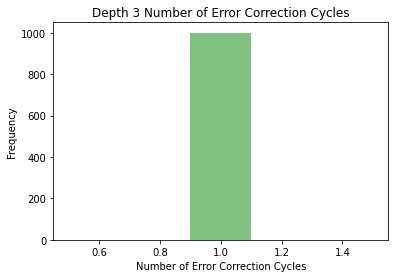

Mean: 1.0
Standard Deviation: 0.0


In [4]:
num_bins_3 = 5
plt.hist(d3_dist, num_bins_3, color='g', alpha=.5)
plt.gca().set(title='Depth 3 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d3 = statistics.pstdev(d3_dist) 
print('Mean: ' + str(mean_d3))
print('Standard Deviation: ' + str(sd_d3))

# Depth 5

In [10]:
circuit = ToricCircuit(5)
d5_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['', 'X00', 'X01', 'X02', 'X03', 'X04', 'X10', 'X11', 'X12', 'X13', 'X14', 'X20',
 'X21', 'X22', 'X23', 'X24', 'X30', 'X31', 'X32', 'X33', 'X34', 'X40', 'X41', 'X42',
 'X43', 'X44', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14',
 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z40', 'Z41',
 'Z42', 'Z43', 'Z44']])
model = keras.models.load_model('MODELS/model_d5.h5')
for i in range(1000):
    count = 0
    while circuit.check_max_errs(5):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])

        prediction = model.predict(vals)
        prediction[prediction>=.5]=1
        prediction[prediction<.5]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1
    circuit.clear_errors()
    d5_dist.append(count)
    
print(d5_dist)

['X00']
[('X00', 'X01')]
Corrected qubit X00
Incorrectly flipped qubit X01
['X01', 'X34', 'Z34']
[('X01', 'X34', 'Z34')]
Corrected qubit X01
Corrected qubit X34
Corrected qubit Z34
['X14']
[('X04', 'X14')]
Incorrectly flipped qubit X04
Corrected qubit X14
['X04', 'X43']
[('X43',)]
Corrected qubit X43
['X04', 'X32']
[('X03', 'X32')]
Incorrectly flipped qubit X03
Corrected qubit X32
['X04', 'X03', 'X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X04', 'X03', 'X30']
[('X03', 'X30', 'X40')]
Corrected qubit X03
Corrected qubit X30
Incorrectly flipped qubit X40
['X04', 'X40', 'X22', 'Z22']
[('X13', 'X22', 'Z22', 'Z40')]
Incorrectly flipped qubit X13
Corrected qubit X22
Corrected qubit Z22
Incorrectly flipped qubit Z40
['X04', 'X40', 'X13', 'X01', 'Z40']
[('X01', 'X12', 'X40', 'X41', 'Z40')]
Corrected qubit X01
Incorrectly flipped qubit X12
Corrected qubit X40
Incorrectly flipped qubit X41
Corrected qubit Z40
['X04', 'X13', 'X12', 'X41', 'X11', 'Z11']
[('X11', 'X41', '

[('X12', 'X23', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit X23
Corrected qubit Z12
['X04', 'X14', 'X24', 'X23', 'X00']
[('X00', 'X01', 'X12')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
['Z23']
[('Z13', 'Z23')]
Incorrectly flipped qubit Z13
Corrected qubit Z23
['X23', 'Z13', 'Z23']
[('X23', 'Z02', 'Z13', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit Z02
Corrected qubit Z13
Corrected qubit Z23
['X24', 'Z02']
[('X24', 'Z02', 'Z03')]
Corrected qubit X24
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X11', 'Z03', 'Z11']
[('X11', 'Z11', 'Z12')]
Corrected qubit X11
Corrected qubit Z11
Incorrectly flipped qubit Z12
['X03', 'Z03', 'Z12']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X03', 'Z12']
[('X02', 'X03', 'Z02', 'Z03')]
Incorrectly flipped qubit X02
Corrected qubit X03
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
['X02', 'X10', 'Z12', 'Z02', 'Z03', 'Z10']
[('X10', 'X11', 'Z10', 'Z20')]
Corrected qubi

[('X12', 'X23')]
Incorrectly flipped qubit X12
Corrected qubit X23
['X11', 'X20', 'X11', 'X12', 'X42']
[('X01', 'X12', 'X42')]
Incorrectly flipped qubit X01
Corrected qubit X12
Corrected qubit X42
['X11', 'X20', 'X11', 'X01', 'Z11']
[('X01', 'X11', 'Z11')]
Corrected qubit X01
Corrected qubit X11
Corrected qubit Z11
['X20', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X20', 'X04']
[('X14',)]
Incorrectly flipped qubit X14
['X20', 'X04', 'X14', 'X32']
[('X21', 'X32')]
Incorrectly flipped qubit X21
Corrected qubit X32
['X20', 'X04', 'X14', 'X21', 'X30', 'Z30']
[('X30', 'X31', 'Z30', 'Z40')]
Corrected qubit X30
Incorrectly flipped qubit X31
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X40', 'Z40']
[('X30', 'X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X30', 'Z30', 'Z21']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X30'

[('X30', 'Z30', 'Z40')]
Corrected qubit X30
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X24', 'X23', 'X31', 'Z41', 'Z40']
[('Z30', 'Z40')]
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X24', 'X23', 'X31', 'Z41', 'Z30', 'Z42']
[('X30', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X33']
[('X33',)]
Corrected qubit X33
['X10']
[('X20',)]
Incorrectly flipped qubit X20
['X10', 'X20', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X10', 'X20', 'X03', 'Z01', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X10', 'X20', 'X20', 'Z01', 'Z20']
[('X10', 'X20', 'Z10', 'Z20')]
Corrected qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X20', 'X02', 'Z01', 'Z10']
[('X02', 'X20', 'Z10', 'Z20')]
Corrected qubit X02
Corre

[('X33', 'X41')]
Corrected qubit X33
Corrected qubit X41
['X34', 'Z41', 'Z23', 'Z04']
[('Z31', 'Z32')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
['X14']
[('X04', 'X14')]
Incorrectly flipped qubit X04
Corrected qubit X14
['X04', 'X12']
[('X12', 'X13')]
Corrected qubit X12
Incorrectly flipped qubit X13
['X04', 'X13', 'X22']
[('X21', 'X32')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X32
['X04', 'X13', 'X22', 'X21', 'X32', 'X14']
[('X03', 'X21', 'X32')]
Incorrectly flipped qubit X03
Corrected qubit X21
Corrected qubit X32
['X04', 'X13', 'X22', 'X14', 'X03', 'Z33']
[('X32', 'Z33')]
Incorrectly flipped qubit X32
Corrected qubit Z33
['Z32']
[('Z32',)]
Corrected qubit Z32
['Z42']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X33', 'Z31', 'Z41', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z31', 'Z41', 'Z31']
[('Z31', 'Z41', 'Z42')]
Corrected qubit Z31
Corrected qubit Z41
Incorrectly

[('X42', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z42
['X34', 'Z02', 'Z02', 'Z42']
[('X24', 'X34', 'Z41')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit Z41
['X24', 'X43', 'Z02', 'Z02', 'Z42', 'Z41', 'Z43']
[('X33', 'X43', 'Z33', 'Z43')]
Incorrectly flipped qubit X33
Corrected qubit X43
Incorrectly flipped qubit Z33
Corrected qubit Z43
['X21', 'Z21']
[('X21', 'Z20', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z20
Corrected qubit Z21
['Z20', 'Z24']
[('X24', 'Z20', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z20
Corrected qubit Z24
['X24', 'Z33']
[('X33', 'Z33')]
Incorrectly flipped qubit X33
Corrected qubit Z33
['X24', 'X33', 'X00', 'Z00']
[('X00', 'X01', 'X33', 'Z00', 'Z01')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit X33
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X24', 'X01', 'X33', 'Z01']
[('X00', 'X01', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit X01
Corrected qubit Z01
['X24', '

[('Z33',)]
Corrected qubit Z33
['X42', 'Z42']
[('X42', 'Z41', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X22', 'Z41']
[('X22', 'Z31', 'Z32', 'Z42')]
Corrected qubit X22
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
Incorrectly flipped qubit Z42
['Z41', 'Z31', 'Z32', 'Z42', 'Z24']
[('Z20', 'Z24')]
Incorrectly flipped qubit Z20
Corrected qubit Z24
['Z41', 'Z31', 'Z32', 'Z42', 'Z20', 'Z14']
[('Z14',)]
Corrected qubit Z14
['X23', 'Z41', 'Z31', 'Z32', 'Z42', 'Z20']
[('X23', 'X33', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit X33
Incorrectly flipped qubit Z23
['X33']
[('X33',)]
Corrected qubit X33
['Z42']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X44', 'Z31', 'Z41', 'Z44']
[('X44', 'Z21', 'Z43', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z43
Corrected qubit Z44
['Z31', 'Z41', 'Z21', 'Z43', 'Z11']
[('Z00', 'Z44')]
Incorrectly flip

[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z41
Corrected qubit Z42
['Z31', 'Z41', 'Z30']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X40', 'X21', 'Z31', 'Z41', 'Z40', 'Z21']
[('X21', 'X31', 'Z11', 'Z30', 'Z40')]
Corrected qubit X21
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X33', 'Z31', 'Z42']
[('X33', 'Z20')]
Corrected qubit X33
Incorrectly flipped qubit Z20
['X22', 'Z31', 'Z42', 'Z20']
[('X21', 'X22', 'X32')]
Incorrectly flipped qubit X21
Corrected qubit X22
Incorrectly flipped qubit X32
['X21', '

[('X23', 'Z22', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit Z22
Corrected qubit Z23
['X24', 'X30', 'X23', 'Z02', 'Z13', 'Z22']
[('X23', 'Z22', 'Z23', 'Z40')]
Corrected qubit X23
Corrected qubit Z22
Incorrectly flipped qubit Z23
Incorrectly flipped qubit Z40
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'Z33']
[('X33', 'Z33')]
Incorrectly flipped qubit X33
Corrected qubit Z33
['X24', 'X33', 'X21']
[('X21', 'X32')]
Corrected qubit X21
Incorrectly flipped qubit X32
['X24', 'X33', 'X32', 'Z24']
[('X21', 'Z24')]
Incorrectly flipped qubit X21
Corrected qubit Z24
['X24', 'X33', 'X32', 'X21', 'X22']
[('X21', 'X22')]
Corrected qubit X21
Corrected qubit X22
['X24', 'X33', 'X32', 'X03']
[('X03', 'X14', 'X31', 'X32')]
Corrected qubit X03
Incorrectly flipped qubit X14
Incorrectly flipped qubit X31
Corrected qubit X32
['X24', 'X33', 'X14', 'X31', 'X02', 'Z02']
[('X02', 'X03', 'X32', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit X03
Incorrectly f

Incorrectly flipped qubit Z14
Corrected qubit Z21
['X10', 'X20', 'X04', 'Z14', 'Z33']
[('X14', 'Z14')]
Incorrectly flipped qubit X14
Corrected qubit Z14
['X10', 'X20', 'X04', 'X14', 'X31', 'Z33', 'Z31']
[('Z31', 'Z32')]
Corrected qubit Z31
Incorrectly flipped qubit Z32
['Z22']
[('Z22',)]
Corrected qubit Z22
['X41']
[('X41',)]
Corrected qubit X41
['Z13']
[('X13', 'Z13')]
Incorrectly flipped qubit X13
Corrected qubit Z13
['X13', 'X44', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X13', 'X41', 'Z41']
[('X13', 'X41', 'Z41')]
Corrected qubit X13
Corrected qubit X41
Corrected qubit Z41
['Z13']
[('X13', 'Z13')]
Incorrectly flipped qubit X13
Corrected qubit Z13
['X13', 'X24', 'Z24']
[('X13', 'X24', 'Z13', 'Z24')]
Corrected qubit X13
Corrected qubit X24
Incorrectly flipped qubit Z13
Corrected qubit Z24
['Z13', 'Z00']
[('X13', 'Z00', 'Z10', 'Z11', 'Z13')]
Incorrectly flipped qubit X13
Corrected qubit Z00
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Corrected q

[('X22', 'X23', 'Z22', 'Z23', 'Z32')]
Corrected qubit X22
Incorrectly flipped qubit X23
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z23
Incorrectly flipped qubit Z32
['X44', 'Z44']
[('X43', 'X44', 'Z43', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X43', 'X33', 'Z43', 'Z33']
[('X44',)]
Incorrectly flipped qubit X44
['X43', 'X33', 'X44', 'X14', 'Z43', 'Z33']
[()]
['X32']
[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['Z32', 'Z30']
[('Z30', 'Z31', 'Z32')]
Corrected qubit Z30
Incorrectly flipped qubit Z31
Corrected qubit Z32
['X24', 'Z31']
[('X24', 'X34', 'Z20', 'Z31', 'Z41')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z20
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X34', 'X42', 'Z20', 'Z41', 'Z42']
[('X33', 'X34', 'Z20')]
Incorrectly flipped qubit X33
Corrected qubit X34
Corrected qubit Z20
['X42', 'X33', 'Z41', 'Z42', 'Z14']
[('X41', 'Z14')]
Incorrec

[('X21', 'X32')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X32
['X40', 'X31', 'X21', 'X32', 'X41', 'Z41']
[('X32', 'X42', 'Z42')]
Corrected qubit X32
Incorrectly flipped qubit X42
Incorrectly flipped qubit Z42
['Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X42', 'Z43', 'Z42']
[('X42', 'Z41', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X11', 'Z43', 'Z41', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X03', 'Z43', 'Z41']
[('X03', 'X04')]
Corrected qubit X03
Incorrectly flipped qubit X04
['X04', 'X32', 'Z43', 'Z41']
[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['X04', 'Z43', 'Z41', 'Z32', 'Z21']
[('Z14', 'Z22')]
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z22
['Z12']
[('Z12',)]
Corrected qubit Z12
['X44', 'Z44']
[('X43', 'X44', 'Z43', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X43', 'X11', '

[('X40', 'X44', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit X44
Corrected qubit Z40
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z03', 'Z12', 'Z33']
[('X44', 'Z22', 'Z33')]
Incorrectly flipped qubit X44
Incorrectly flipped qubit Z22
Corrected qubit Z33
['X44', 'X11', 'Z03', 'Z12', 'Z22', 'Z11']
[('X11', 'X44', 'Z11', 'Z12')]
Corrected qubit X11
Corrected qubit X44
Corrected qubit Z11
Corrected qubit Z12
['Z03', 'Z22', 'Z23']
[('Z12', 'Z13')]
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
['Z03', 'Z22', 'Z23', 'Z12', 'Z13', 'Z42']
[('Z02', 'Z03', 'Z12', 'Z31', 'Z32', 'Z41', 'Z42')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z12
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X32']
[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['Z32', 'Z13']
[('Z03', 'Z13', 'Z32')]
Incorrectly flipped qubit 

[('X20',)]
Incorrectly flipped qubit X20
['X10', 'X20', 'X32']
[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['X10', 'X20', 'X30', 'Z32']
[('X40', 'Z32', 'Z41')]
Incorrectly flipped qubit X40
Corrected qubit Z32
Incorrectly flipped qubit Z41
['X10', 'X20', 'X30', 'X40', 'Z41', 'Z34']
[('X34', 'Z34', 'Z41', 'Z42')]
Incorrectly flipped qubit X34
Corrected qubit Z34
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X14']
[('X04', 'X14')]
Incorrectly flipped qubit X04
Corrected qubit X14
['X04', 'X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X04', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X04', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X04', 'Z40']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X04', 'X40', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X04', 'X40', 'Z12']
[('X40', 'Z03')]
Corrected qubit X40
Incorrectly flipped qubit Z03
['X04', 'X14', 'Z12', 'Z03'

[('X21', 'X32', 'Z31', 'Z32')]
Corrected qubit X21
Incorrectly flipped qubit X32
Corrected qubit Z31
Corrected qubit Z32
['X32', 'Z42', 'Z01']
[('X31', 'X32', 'Z10', 'Z32')]
Incorrectly flipped qubit X31
Corrected qubit X32
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z32
['X31', 'Z42', 'Z01', 'Z10', 'Z32', 'Z21']
[('X31', 'Z30', 'Z31')]
Corrected qubit X31
Incorrectly flipped qubit Z30
Incorrectly flipped qubit Z31
['Z32']
[('Z32',)]
Corrected qubit Z32
['X30']
[('X30', 'X40')]
Corrected qubit X30
Incorrectly flipped qubit X40
['X40', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X40', 'X20']
[()]
['X40', 'X20', 'X42', 'Z42']
[('X41', 'X42', 'Z41', 'Z42')]
Incorrectly flipped qubit X41
Corrected qubit X42
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X40', 'X20', 'X41', 'X23', 'Z41', 'Z23']
[('X23',)]
Corrected qubit X23
['X40', 'X20', 'X41', 'X33', 'Z41', 'Z23', 'Z33']
[('X33', 'X34', 'Z34')]
Corrected qubit X33
Incorrectly flipped qubit X3

[('X04', 'X14', 'X44', 'Z04', 'Z14', 'Z44')]
Incorrectly flipped qubit X04
Corrected qubit X14
Corrected qubit X44
Incorrectly flipped qubit Z04
Corrected qubit Z14
Corrected qubit Z44
['X04', 'Z04', 'Z44']
[('X04', 'Z04', 'Z14', 'Z44')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
Corrected qubit Z44
['Z14', 'Z10']
[('X14', 'Z10', 'Z14', 'Z24')]
Incorrectly flipped qubit X14
Corrected qubit Z10
Corrected qubit Z14
Incorrectly flipped qubit Z24
['X14', 'X22', 'Z24', 'Z22']
[('X13', 'Z13', 'Z14')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z14
['Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X44', 'Z44']
[('X43', 'X44', 'Z43', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X43', 'X11', 'Z43', 'Z11']
[('X11', 'X44', 'Z10', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit X44
Incorrectly flipped qubit Z10
Corrected qubit Z11
['

[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X10', 'X20', 'Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X10', 'X20', 'X20', 'Z03', 'Z12', 'Z20']
[('X20', 'Z20', 'Z21')]
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z21
['X10', 'X20', 'Z03', 'Z12', 'Z21', 'Z40']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit Z30
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z03', 'Z12', 'Z41']
[('Z11', 'Z31', 'Z41')]
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z31
Corrected qubit Z41
['Z03', 'Z12', 'Z11', 'Z31', 'Z10']
[('Z20', 'Z31', 'Z41')]
Incorrectly flipped qubit Z20
Corrected qubit Z31
Incorrectly flipped qubit Z41
['Z34']
[('X34', 'Z34')]
Incorrectly flipped qubit X34
Corrected qubit Z34
['X34', 'X41']
[('X41', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z41
['X34', 'Z41', 'Z41']
[('

[('X10', 'X20', 'Z10', 'Z20')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X20', 'X22', 'Z11', 'Z12', 'Z02', 'Z20']
[('X21', 'Z20')]
Incorrectly flipped qubit X21
Corrected qubit Z20
['X32']
[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['Z32', 'Z00']
[('Z32', 'Z41')]
Corrected qubit Z32
Incorrectly flipped qubit Z41
['X41', 'Z00', 'Z41', 'Z41']
[('X40', 'X41', 'Z01', 'Z11', 'Z41')]
Incorrectly flipped qubit X40
Corrected qubit X41
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Corrected qubit Z41
['X40', 'Z00', 'Z41', 'Z01', 'Z11', 'Z10']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X44']
[('X44', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z44
['Z44', 'Z14']
[('Z14', 'Z43', 'Z44')]
Corrected qubit Z14
Incorrectly flipped qubit Z43
Corrected qubit Z44
['Z43', 'Z02']
[('X02', 'Z02', 'Z03', 'Z43')]
Incorrectly flipped qubit X0

[('X02', 'Z02', 'Z12', 'Z30')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z12
Corrected qubit Z30
['X23', 'Z23']
[('X23', 'Z13', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit Z13
Corrected qubit Z23
['X44', 'Z13']
[('X44', 'Z13')]
Corrected qubit X44
Corrected qubit Z13
['X40']
[('X30', 'X40')]
Incorrectly flipped qubit X30
Corrected qubit X40
['X30', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X30', 'X13']
[('X13',)]
Corrected qubit X13
['X30', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X30', 'X01', 'Z01']
[('X01', 'X40', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit X40
Corrected qubit Z01
['X30', 'X40', 'Z04']
[('X04', 'Z04')]
Incorrectly flipped qubit X04
Corrected qubit Z04
['X30', 'X40', 'X04', 'X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X30', 'X40', 'X04', 'Z31']
[('X31', 'Z31', 'Z41')]
Incorrectly flipped qubit X31
Corrected qubit Z3

[('X42', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z42
['X21', 'Z00', 'Z42', 'Z21']
[('X11', 'X21', 'X31', 'Z11', 'Z21', 'Z31')]
Incorrectly flipped qubit X11
Corrected qubit X21
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z11
Corrected qubit Z21
Incorrectly flipped qubit Z31
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z34']
[('X34', 'Z34')]
Incorrectly flipped qubit X34
Corrected qubit Z34
['X34', 'X12']
[('X12', 'X23')]
Corrected qubit X12
Incorrectly flipped qubit X23
['X34', 'X23', 'X20', 'Z20']
[('X20', 'Z20', 'Z21')]
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z21
['X34', 'X23', 'X31', 'Z21']
[('Z21', 'Z30')]
Corrected qubit Z21
Incorrectly flipped qubit Z30
['X34', 'X23', 'X31', 'Z30', 'Z13']
[('Z21', 'Z30')]
Incorrectly flipped qubit Z21
Corrected qubit Z30
['X34', 'X23', 'X31', 'X11', 'Z13', 'Z21', 'Z11']
[('X11', 'X21', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit X21
Corrected qubit Z11
['X2

[('X00', 'X01', 'Z01')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit Z01
['X40', 'X41', 'X01', 'X12', 'Z00', 'Z01', 'Z12']
[('X01', 'X12')]
Corrected qubit X01
Corrected qubit X12
['X40', 'X41', 'X04', 'Z00', 'Z01', 'Z12']
[('X12', 'Z12')]
Incorrectly flipped qubit X12
Corrected qubit Z12
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z02', 'Z10']
[('X10', 'Z02', 'Z03', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z10
['X10', 'X03', 'Z03', 'Z03']
[('X03',)]
Corrected qubit X03
['X10', 'Z03', 'Z03', 'Z01']
[('X10', 'X11', 'Z10', 'Z11')]
Corrected qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
['X31']
[('X31',)]
Corrected qubit X31
['Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
['X20', 'Z02', 'Z12', 'Z20']
[('X20', 'Z20', 'Z21')]
Corrected qubit X20
Corr

[('X30', 'X31', 'Z30', 'Z31')]
Corrected qubit X30
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z30
Corrected qubit Z31
['X31', 'Z42', 'Z30', 'Z20']
[('X31', 'Z10', 'Z31', 'Z32')]
Corrected qubit X31
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
['X40', 'Z40']
[('X30', 'X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X30', 'X24', 'Z30']
[('X23', 'X30', 'X34', 'Z30')]
Incorrectly flipped qubit X23
Corrected qubit X30
Incorrectly flipped qubit X34
Corrected qubit Z30
['X24', 'X23', 'X34', 'Z33']
[('X23', 'X33', 'Z33')]
Corrected qubit X23
Incorrectly flipped qubit X33
Corrected qubit Z33
['X24', 'X34', 'X33', 'X40', 'Z40']
[('X30', 'X33', 'X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Corrected qubit X33
Corrected qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X24', 'X34', 'X30', 'Z30', 'Z13']
[('X30', 'Z30')]
Corrected qubit X30
Corrected 

[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X10', 'Z00']
[('X10', 'X11', 'Z10', 'Z11')]
Corrected qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
['X11', 'X21', 'Z00', 'Z10', 'Z11']
[('X11', 'X21', 'Z11')]
Corrected qubit X11
Corrected qubit X21
Corrected qubit Z11
['X13', 'Z00', 'Z10']
[('X13', 'Z13', 'Z24')]
Corrected qubit X13
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z24
['Z00', 'Z10', 'Z13', 'Z24', 'Z32']
[('Z02', 'Z03', 'Z10', 'Z32', 'Z41', 'Z42')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z10
Corrected qubit Z32
Incorrectly flipped qubit Z41
Incorrectly flipped qubit Z42
['X24']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X01']
[('X01', 'X34')]
Corrected qubit X01
Corrected qubit X34
['X40', 'Z40']
[('X30', 'X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z

[('X21', 'X32')]
Corrected qubit X21
Incorrectly flipped qubit X32
['X32', 'Z10']
[('X10', 'X32', 'Z10', 'Z32')]
Incorrectly flipped qubit X10
Corrected qubit X32
Corrected qubit Z10
Incorrectly flipped qubit Z32
['X10', 'X02', 'Z32', 'Z02']
[('X02', 'Z02', 'Z03', 'Z12', 'Z32')]
Corrected qubit X02
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
Corrected qubit Z32
['X10', 'Z03', 'Z12', 'Z02']
[('Z12',)]
Corrected qubit Z12
['X10', 'X40', 'Z03', 'Z02']
[()]
['X10', 'X40', 'Z03', 'Z02', 'Z11']
[('X11', 'Z11')]
Incorrectly flipped qubit X11
Corrected qubit Z11
['X10', 'X40', 'X11', 'X23', 'Z03', 'Z02']
[('X12', 'X23', 'X41')]
Incorrectly flipped qubit X12
Corrected qubit X23
Incorrectly flipped qubit X41
['X34', 'Z34']
[('X24', 'X34', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
['X24', 'X03']
[('X03', 'X33')]
Corrected qubit X03
Incorrectly flipped qubit X33
['X24', 'X33', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13

[('X24', 'X34', 'Z34', 'Z41')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
Incorrectly flipped qubit Z41
['Z12']
[('Z12',)]
Corrected qubit Z12
['X14']
[('X04', 'X14')]
Incorrectly flipped qubit X04
Corrected qubit X14
['X04', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X04', 'Z14']
[('X14', 'Z14')]
Incorrectly flipped qubit X14
Corrected qubit Z14
['X04', 'X14', 'X00', 'Z00']
[('X00', 'X01', 'Z00', 'Z01')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X04', 'X14', 'X01', 'X11', 'Z01']
[('X00', 'X01', 'Z00', 'Z01', 'Z10')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z10
['Z21']
[('Z21',)]
Corrected qubit Z21
['Z22']
[('Z22',)]
Corrected qubit Z22
['X04', 'Z04']
[('X04', 'X14', 'Z04', 'Z14')]
Corrected qubit X04
Incorrectly flipped qubit X14
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X14'

[('X24', 'Z10', 'Z20')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X00', 'X24', 'Z41', 'Z10', 'Z04']
[('X24', 'X34', 'Z10', 'Z41')]
Corrected qubit X24
Incorrectly flipped qubit X34
Corrected qubit Z10
Corrected qubit Z41
['X00', 'X34', 'X03', 'Z04']
[('X03', 'X14')]
Corrected qubit X03
Incorrectly flipped qubit X14
['X00', 'X34', 'X14', 'X43', 'Z04', 'Z43']
[('Z33', 'Z43', 'Z44')]
Incorrectly flipped qubit Z33
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X01']
[('X01',)]
Corrected qubit X01
['X33']
[('X33',)]
Corrected qubit X33
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X30', 'Z22']
[('X44', 'Z22')]
Incorrectly flipped qubit X44
Corrected qubit Z22
['X30', 'X44', 'X44']
[('X30', 'X40')]
Corrected qubit X30
Incorrectly flipped qubit X40
['X44', 'X44', 'X40', 'X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24


[('X41',)]
Corrected qubit X41
['X42']
[('X42', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z42
['Z42', 'Z34']
[('X34', 'Z34', 'Z41', 'Z42')]
Incorrectly flipped qubit X34
Corrected qubit Z34
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X34', 'Z41', 'Z12']
[('Z02', 'Z12', 'Z32', 'Z41', 'Z42')]
Incorrectly flipped qubit Z02
Corrected qubit Z12
Incorrectly flipped qubit Z32
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X34', 'X22', 'Z02', 'Z32', 'Z42']
[('X22', 'X23', 'Z22', 'Z32')]
Corrected qubit X22
Incorrectly flipped qubit X23
Incorrectly flipped qubit Z22
Corrected qubit Z32
['X34', 'X23', 'Z02', 'Z42', 'Z22', 'Z21']
[('X23', 'Z02', 'Z12', 'Z31', 'Z32')]
Corrected qubit X23
Corrected qubit Z02
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
['X03']
[('X03', 'X14')]
Corrected qubit X03
Incorrectly flipped qubit X14
['X14', 'Z20']
[('X03', 'Z20')]
Incorrectly flipped qubit X03
Corrected qubit Z20
['X14', 'X03', 'Z32']
[

[('X44', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z44
['X13', 'X22', 'Z43', 'Z44', 'Z22']
[('X22', 'X32', 'Z22', 'Z32')]
Corrected qubit X22
Incorrectly flipped qubit X32
Corrected qubit Z22
Incorrectly flipped qubit Z32
['X13', 'X32', 'Z43', 'Z44', 'Z32', 'Z12']
[('X22', 'X32', 'Z03', 'Z12', 'Z22', 'Z32')]
Incorrectly flipped qubit X22
Corrected qubit X32
Incorrectly flipped qubit Z03
Corrected qubit Z12
Incorrectly flipped qubit Z22
Corrected qubit Z32
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X43', 'Z43']
[('X43', 'X44', 'Z33', 'Z43', 'Z44')]
Corrected qubit X43
Incorrectly flipped qubit X44
Incorrectly flipped qubit Z33
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X44', 'X14', 'Z33', 'Z44']
[('X44',)]
Corrected qubit X44
['X14', 'X03', 'Z33', 'Z44', 'Z03']
[('X03', 'Z02', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X14', 'X0

['X23']
[('X23',)]
Corrected qubit X23
['X12']
[('X12',)]
Corrected qubit X12
['X34', 'Z34']
[('X24', 'X34', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
['X24', 'X43', 'Z43']
[('X33', 'X43', 'Z33', 'Z43')]
Incorrectly flipped qubit X33
Corrected qubit X43
Incorrectly flipped qubit Z33
Corrected qubit Z43
['X24', 'X33', 'Z33', 'Z12']
[('Z22', 'Z32', 'Z33')]
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z32
Corrected qubit Z33
['X24', 'X33', 'X43', 'Z12', 'Z22', 'Z32', 'Z43']
[('X44', 'Z02', 'Z03', 'Z41')]
Incorrectly flipped qubit X44
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z41
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'X30']
[()]
['X20', 'X30', 'X24']
[('X24', 'X30', 'X34')]
Corrected qubit X24
Corrected qubit X30
Incorrectly flipped qubit X34
['X20', 'X34', 'Z43']
[('X34', 'Z34', 'Z43')]
Corrected qubit X34
Incorrectly flipped qubit Z34
Corrected qubit Z43

[('X04', 'X13', 'X14', 'Z14')]
Corrected qubit X04
Incorrectly flipped qubit X13
Incorrectly flipped qubit X14
Incorrectly flipped qubit Z14
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X42', 'Z42']
[('X42', 'Z41', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X02', 'Z41', 'Z02']
[('X02', 'Z02', 'Z41')]
Corrected qubit X02
Corrected qubit Z02
Corrected qubit Z41
['X30']
[('X30', 'X40')]
Corrected qubit X30
Incorrectly flipped qubit X40
['X40', 'Z14']
[('X14', 'Z14')]
Incorrectly flipped qubit X14
Corrected qubit Z14
['X40', 'X14', 'Z14']
[('X04', 'X14', 'Z14')]
Incorrectly flipped qubit X04
Corrected qubit X14
Corrected qubit Z14
['X40', 'X04', 'X23']
[('X13', 'X23', 'X41')]
Incorrectly flipped qubit X13
Corrected qubit X23
Incorrectly flipped qubit X41
['X40', 'X04', 'X13', 'X41', 'Z12']
[('X12', 'Z12')]
Incorrectly flipped qubit X12
Corrected qubit Z12
['X40', 'X04', 'X13', 'X41', 'X12', 'Z11']
[('X01', 'X11', 'X41', 'Z11

[('X20', 'Z20')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z20
['X30', 'Z30']
[('X30', 'X40', 'Z30', 'Z40')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X40', 'X12', 'Z40', 'Z12']
[('X12', 'Z12', 'Z40')]
Corrected qubit X12
Corrected qubit Z12
Corrected qubit Z40
['X40', 'Z11']
[('X40', 'Z01', 'Z11', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit Z01
Corrected qubit Z11
Incorrectly flipped qubit Z40
['X33', 'Z01', 'Z40']
[('X00', 'X33', 'X40', 'Z00', 'Z40')]
Incorrectly flipped qubit X00
Corrected qubit X33
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z00
Corrected qubit Z40
['X00', 'X40', 'X13', 'Z01', 'Z00']
[('X13', 'X41')]
Corrected qubit X13
Incorrectly flipped qubit X41
['X00', 'X40', 'X41', 'X10', 'Z01', 'Z00']
[('X01', 'X11')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X11
['Z13']
[('X13', 'Z13')]
Incorrectly flipped qubit X13
Corrected qubit Z13
['X13', 'X21']
[('X13', 'X21',

[('X13', 'Z13', 'Z14')]
Corrected qubit X13
Corrected qubit Z13
Incorrectly flipped qubit Z14
['X04', 'X24', 'X23', 'X20', 'Z04', 'Z14', 'Z20']
[('X20', 'Z13', 'Z20', 'Z24')]
Corrected qubit X20
Incorrectly flipped qubit Z13
Corrected qubit Z20
Incorrectly flipped qubit Z24
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['Z34']
[('X34', 'Z34')]
Incorrectly flipped qubit X34
Corrected qubit Z34
['X34', 'X21']
[('X21', 'X32', 'Z20')]
Corrected qubit X21
Incorrectly flipped qubit X32
Incorrectly flipped qubit Z20
['X34', 'X32', 'X43', 'Z20', 'Z43']
[('X44', 'Z20')]
Incorrectly flipped qubit X44
Corrected qubit Z20
['X34', 'X32', 'X43', 'X44', 'X21', 'Z43']
[('X34', 'Z34', 'Z43')]
Corrected qubit X34
Incorrectly flipped qubit Z34
Corrected qubit Z43
['X32', 'X43', 'X44', 'X21', 'Z34', 'Z32']
[('Z34',)]
Corrected qubit Z34
['X32', 'X43', 'X44', 'X21', 'X42', 'Z32', 'Z42']
[('X32', 'X33', 'X42')]
Corrected qubit X32
Incorrectly flipped qubit X33
Corrected qubit X42
[

[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['Z32', 'Z42']
[('Z22', 'Z33')]
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z33
['Z32', 'Z42', 'Z22', 'Z33', 'Z13']
[('Z22', 'Z23', 'Z33')]
Corrected qubit Z22
Incorrectly flipped qubit Z23
Corrected qubit Z33
['Z32', 'Z42', 'Z13', 'Z23', 'Z22']
[('Z12', 'Z22', 'Z32')]
Incorrectly flipped qubit Z12
Corrected qubit Z22
Corrected qubit Z32
['X44', 'Z42', 'Z13', 'Z23', 'Z12']
[('X44', 'Z11', 'Z22', 'Z32', 'Z41')]
Corrected qubit X44
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z32
Incorrectly flipped qubit Z41
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
['Z02', 'Z12', 'Z20']
[('X20', 'Z20', 'Z21')]
Incorrectly flipped qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z21
['X20', 'Z02', 'Z12', 'Z21', 'Z41']
[('X20', 'Z20', 'Z31'

['X34', 'Z41', 'Z22']
[('Z22', 'Z32')]
Corrected qubit Z22
Incorrectly flipped qubit Z32
['X34', 'Z41', 'Z32', 'Z01']
[('X24', 'X33', 'Z33')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Incorrectly flipped qubit Z33
['X40']
[('X30', 'X40')]
Incorrectly flipped qubit X30
Corrected qubit X40
['X30', 'X10']
[()]
['X30', 'X10', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X30', 'X10', 'X23', 'Z23']
[('X23', 'Z23', 'Z30')]
Corrected qubit X23
Corrected qubit Z23
Incorrectly flipped qubit Z30
['X30', 'X10', 'X42', 'Z30', 'Z42']
[('Z30', 'Z31')]
Corrected qubit Z30
Incorrectly flipped qubit Z31
['X30', 'X10', 'X42', 'X21', 'Z42', 'Z31', 'Z21']
[('X41', 'X42')]
Incorrectly flipped qubit X41
Corrected qubit X42
['Z21']
[('Z21',)]
Corrected qubit Z21
['X34', 'Z34']
[('X24', 'X34', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
['X24', 'X31', 'Z31']
[('X24', 'X31', 'Z20', 'Z31')]
Corrected qubit X24
Corrected qubit X31
Inc

[('X20', 'Z10', 'Z13', 'Z20')]
Corrected qubit X20
Corrected qubit Z10
Corrected qubit Z13
Corrected qubit Z20
['Z22']
[('Z22',)]
Corrected qubit Z22
['Z31']
[('Z20', 'Z31', 'Z41')]
Incorrectly flipped qubit Z20
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X24', 'Z20', 'Z41']
[('X24', 'X34', 'Z20', 'Z31', 'Z41')]
Corrected qubit X24
Incorrectly flipped qubit X34
Corrected qubit Z20
Incorrectly flipped qubit Z31
Corrected qubit Z41
['X34', 'X13', 'Z31']
[('X24', 'Z31', 'Z41')]
Incorrectly flipped qubit X24
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X34', 'X13', 'X24', 'X02', 'Z41']
[('X02', 'Z41')]
Corrected qubit X02
Corrected qubit Z41
['X34', 'X13', 'X24', 'X22', 'Z22']
[('X22', 'X32', 'Z22', 'Z32')]
Corrected qubit X22
Incorrectly flipped qubit X32
Corrected qubit Z22
Incorrectly flipped qubit Z32
['X34', 'X13', 'X24', 'X32', 'X14', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X34', 'X13', 'X24', 'X14', 'X14', 'Z14']
[('X13', 'X14', 'Z13', 'Z14')

[('X04', 'X42')]
Corrected qubit X04
Corrected qubit X42
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X20']
[('X20',)]
Corrected qubit X20
['Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['Z44', 'Z24']
[('Z24', 'Z34')]
Corrected qubit Z24
Incorrectly flipped qubit Z34
['Z44', 'Z34', 'Z31']
[('Z24', 'Z31', 'Z41')]
Incorrectly flipped qubit Z24
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X44', 'Z44', 'Z34', 'Z24', 'Z41']
[('X44',)]
Corrected qubit X44
['Z44', 'Z34', 'Z24', 'Z41', 'Z01']
[('Z00', 'Z24', 'Z41')]
Incorrectly flipped qubit Z00
Corrected qubit Z24
Corrected qubit Z41
['Z44', 'Z34', 'Z01', 'Z00', 'Z23']
[('Z23', 'Z24')]
Corrected qubit Z23
Incorrectly flipped qubit Z24
['Z44', 'Z34', 'Z01', 'Z00', 'Z24', 'Z00']
[('Z00', 'Z24')]
Corrected qubit Z00
Corrected qubit Z24
['Z44', 'Z34', 'Z01', 'Z00', 'Z42']
[('Z24', 'Z31', 'Z34', 'Z41', 'Z42')]
Incorrectly flipped qubit Z24
Incorrectly flipped qubit Z31
Corrected qubit

[()]
['X30', 'X10', 'Z12']
[('X11', 'Z11', 'Z12')]
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z11
Corrected qubit Z12
['X30', 'X10', 'X11', 'Z11', 'Z23']
[('X40', 'Z01', 'Z11', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z01
Corrected qubit Z11
Incorrectly flipped qubit Z40
['Z11']
[('Z11',)]
Corrected qubit Z11
['X42']
[('X42', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z42
['X20', 'Z42', 'Z20']
[('X20', 'Z20', 'Z31')]
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z31
['X40', 'Z42', 'Z31']
[('X30', 'X31', 'Z30', 'Z31')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z30
Corrected qubit Z31
['X40', 'X30', 'X31', 'Z42', 'Z30', 'Z23']
[('X31', 'Z30', 'Z31')]
Corrected qubit X31
Corrected qubit Z30
Incorrectly flipped qubit Z31
['X40', 'X30', 'X33', 'Z42', 'Z23', 'Z31', 'Z33']
[('X33', 'Z20', 'Z33')]
Corrected qubit X33
Incorrectly flipped qubit Z20
Corrected qubit Z33
['X41', 'Z41']
[('

[('X10', 'X32', 'X43', 'Z10')]
Corrected qubit X10
Incorrectly flipped qubit X32
Corrected qubit X43
Incorrectly flipped qubit Z10
['X32', 'X11', 'Z44', 'Z43', 'Z10']
[('X10', 'X21', 'X32', 'Z10')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X21
Corrected qubit X32
Corrected qubit Z10
['X11', 'X10', 'X21', 'Z44', 'Z43', 'Z40']
[('X21',)]
Corrected qubit X21
['X11', 'X10', 'X04', 'Z44', 'Z43', 'Z40']
[('X40',)]
Incorrectly flipped qubit X40
['X21']
[('X21', 'X32')]
Corrected qubit X21
Incorrectly flipped qubit X32
['X32', 'Z14']
[('X32', 'Z14')]
Corrected qubit X32
Corrected qubit Z14
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X03', 'Z03', 'Z12']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X04', 'Z12']
[('Z03', 'Z12', 'Z13')]
Incorrectly flipped qubit Z03
Corrected qubit Z12
Incorrectly flipped qubit Z13
['X04', 'X12', 'Z03', 'Z13']
[('X13', 'Z13')]
Incorrectly flipped qubit X13
Corrected q

[('X30', 'X40', 'Z30', 'Z40')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X14', 'X40', 'X34', 'Z40']
[('X30', 'X40', 'Z40')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit Z40
['X14', 'X34', 'X30', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X34', 'X30', 'X22']
[('X23', 'Z23')]
Incorrectly flipped qubit X23
Incorrectly flipped qubit Z23
['X34', 'X30', 'X22', 'X23', 'Z23', 'Z01']
[('X31', 'X40')]
Incorrectly flipped qubit X31
Incorrectly flipped qubit X40
['X31']
[('X31',)]
Corrected qubit X31
['X20']
[('X20',)]
Corrected qubit X20
['X22']
[('X22',)]
Corrected qubit X22
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z44']
[('X30', 'X40', 'X41', 'X44', 'Z43', 'Z44')]
Corrected qubit X30
Incorrectly flipped qubit

### D5 distributions

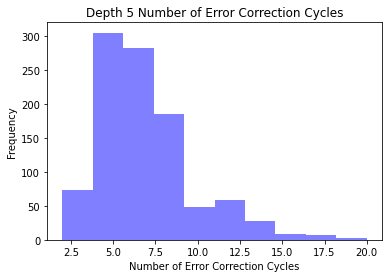

Mean: 6.844
Standard Deviation: 2.8802194360846882


In [11]:
num_bins_5 = 10
plt.hist(d5_dist, num_bins_5, facecolor='blue', alpha=.5)
plt.gca().set(title='Depth 5 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d5 = sum(d5_dist) / len(d5_dist)
mean_d5 = sum(d5_dist) / len(d5_dist)
sd_d5 = statistics.pstdev(d5_dist) 
print('Mean: ' + str(mean_d5))
print('Standard Deviation: ' + str(sd_d5))

# Depth 7

In [12]:
circuit = ToricCircuit(7)
d7_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['','X00', 'X01', 'X02', 'X03', 'X04','X05', 'X06', 'X10', 'X11', 'X12', 'X13',
 'X14', 'X15', 'X16', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X30', 'X31',
 'X32', 'X33', 'X34', 'X35', 'X36', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46',
 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X60', 'X61', 'X62', 'X63', 'X64',
 'X65', 'X66', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06', 'Z10', 'Z11', 'Z12',
 'Z13', 'Z14', 'Z15', 'Z16', 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z25', 'Z26', 'Z30',
 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z40', 'Z41', 'Z42', 'Z43', 'Z44', 'Z45',
 'Z46', 'Z50', 'Z51', 'Z52', 'Z53', 'Z54', 'Z55', 'Z56', 'Z60', 'Z61', 'Z62', 'Z63',
 'Z64', 'Z65', 'Z66']])
model = keras.models.load_model('MODELS/model_d7.h5')

for i in range(1000):
    count = 0
    while circuit.check_max_errs(7):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])

        prediction = model.predict(vals)
        prediction[prediction>=.4]=1
        prediction[prediction<.4]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1

    circuit.clear_errors()
    d7_dist.append(count)
    
print(d7_dist)

['X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['Z53']
[('Z53',)]
Corrected qubit Z53
['Z11']
[('Z11',)]
Corrected qubit Z11
['X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['Z64', 'Z16']
[('Z16', 'Z63')]
Corrected qubit Z16
Incorrectly flipped qubit Z63
['X54', 'Z64', 'Z63']
[('X54',)]
Corrected qubit X54
['Z64', 'Z63', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X34', 'Z64', 'Z63', 'Z34']
[('X34', 'X46', 'X56', 'Z34')]
Corrected qubit X34
Incorrectly flipped qubit X46
Corrected qubit X56
Corrected qubit Z34
['X46', 'Z64', 'Z63', 'Z51']
[('X46', 'X55', 'X56', 'Z51')]
Corrected qubit X46
Incorrectly flipped qubit X55
Incorrectly flipped qubit X56
Corrected qubit Z51
['X55', 'X56', 'X20', 'Z64', 'Z63', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X55', 'X56', 'X60', 'Z64', 'Z63']
[('X60', 'X64')]
Corrected qubit X60
Incorrectly flipped qubit X64
['X55', 'X56', 'X64', 'X53', 'Z

[('Z14',)]
Corrected qubit Z14
['Z65', 'Z66', 'Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X23', 'Z65', 'Z66', 'Z60']
[('X23', 'Z60')]
Corrected qubit X23
Corrected qubit Z60
['X34', 'Z65', 'Z66']
[('X34',)]
Corrected qubit X34
['Z65', 'Z66', 'Z41']
[('Z41',)]
Corrected qubit Z41
['Z65', 'Z66', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X22', 'Z65', 'Z66']
[('X22',)]
Corrected qubit X22
['Z65', 'Z66', 'Z60']
[('X60', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit Z60
['X60', 'Z65', 'Z66', 'Z41']
[('X60', 'Z41')]
Corrected qubit X60
Corrected qubit Z41
['X41', 'Z65', 'Z66']
[('X41',)]
Corrected qubit X41
['Z65', 'Z66', 'Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X25', 'Z65', 'Z66', 'Z03', 'Z13', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X00', 'Z65', 'Z66', 'Z03', 'Z13', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z65', 'Z66', 'Z03', 'Z13',

[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X11']
[('X11',)]
Corrected qubit X11
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z05']
[('Z04',)]
Incorrectly flipped qubit Z04
['X00', 'Z05', 'Z04', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X36', 'Z05', 'Z04']
[()]
['X36', 'Z05', 'Z04', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X36', 'X11', 'Z05', 'Z04']
[('X11', 'X25')]
Corrected qubit X11
Incorrectly flipped qubit X25
['X36', 'X25', 'X34', 'Z05', 'Z04', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X36', 'X25', 'Z05', 'Z04', 'Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X36', 'X25', 'X20', 'Z05', 'Z04', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X36', 'X25', 'X20', 'X12', 'Z05', 'Z04']
[('X11',)]
Incorrectly flipped qubit X11
['X36', '

['X56', 'X46', 'X42']
[('X42',)]
Corrected qubit X42
['X56', 'X46', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X56', 'X46', 'Z16']
[('Z16',)]
Corrected qubit Z16
['X56', 'X46', 'Z16']
[('Z16',)]
Corrected qubit Z16
['X56', 'X46', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X56', 'X46', 'Z61']
[('Z61',)]
Corrected qubit Z61
['X56', 'X46', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X56', 'X46', 'X32']
[('X32',)]
Corrected qubit X32
['X56', 'X46', 'X13']
[('X13',)]
Corrected qubit X13
['X56', 'X46', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X56', 'X46', 'X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X56', 'X46', 'X55', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X56', 'X46', 'X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X56', 'X46', 'X52']
[('X52',)]
Corrected qubit X52
['X56', 'X46', 'X14']
[('X14',)]
Corrected qubit X14
['X56', 'X46', 'X60']
[('X60',)]
Corrected qubit X60
['X56', 'X46', 'X01'

[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X04']
[('X04',)]
Corrected qubit X04
['X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['Z53']
[('Z53',)]
Corrected qubit Z53
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['Z01']
[('Z00',)]
Incorrectly flipped qubit Z00
['Z01', 'Z00', 'Z15']
[('Z15',)]
Corrected qubit Z15
['X04', 'Z01', 'Z00', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X55', 'Z01', 'Z00', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X46', 'Z01', 'Z00', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['Z01', 'Z00', 'Z52']
[('Z52',)]
Corrected qubit Z52
['Z01', 'Z00', 'Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X46', 'X01', 'Z01', 'Z00']
[('X01', 'X46', 'X56')]
Corrected qu

[('X50', 'X60', 'Z50', 'Z60')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X60', 'Z60', 'Z41']
[('X50', 'X60', 'Z41', 'Z60')]
Incorrectly flipped qubit X50
Corrected qubit X60
Corrected qubit Z41
Corrected qubit Z60
['X50', 'X43', 'Z43']
[('X43', 'X50', 'Z43')]
Corrected qubit X43
Corrected qubit X50
Corrected qubit Z43
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z00']
[('Z00',)]
Corrected qubit Z00
['Z22']
[('Z22',)]
Corrected qubit Z22
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X26', 'Z66']
[('X25', 'Z66')]
Incorrectly flipped qubit X25
Corrected qubit Z66
['X26', 'X25', 'X05']
[('X05', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z05
['X26', 'X25', 'X00', 'Z05']
[('X00', 'X14', 'Z14')]
Corrected qubit X00
Incorrectly flipped qubit X14
Incorrectly flipped qubit Z14
['X26', 'X25', 'X14

['X50', 'Z50']
[('X50', 'X60', 'Z50', 'Z60')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X60', 'X26', 'Z60', 'Z26']
[('X26', 'X60', 'Z26', 'Z60')]
Corrected qubit X26
Corrected qubit X60
Corrected qubit Z26
Corrected qubit Z60
['X06', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X35']
[('X35',)]
Corrected qubit X35
['X44', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['Z22']
[('Z22',)]
Corrected qubit Z22
['Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X41', 'Z60']
[('X41', 'X60', 'Z41', 'Z50', 'Z60')]
Corrected qubit X41
Incorrectly flipped qubit X60
Incorrectly flipped qubit Z41
Incorrectly flipped qubit Z50
Corrected qubit Z60
['X60', 'X10', 'Z41', 'Z50']
[('X10', 'X50', 'X60', 'Z31', 'Z41', 'Z50', 'Z60')]
Corrected

[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X40', 'X31', 'Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X40', 'X31', 'X20', 'X41', 'Z41']
[('X21', 'X41', 'Z21', 'Z41')]
Incorrectly flipped qubit X21
Corrected qubit X41
Incorrectly flipped qubit Z21
Corrected qubit Z41
['X40', 'X31', 'X20', 'X21', 'X56', 'Z21']
[('X56', 'Z21')]
Corrected qubit X56
Corrected qubit Z21
['X40', 'X31', 'X20', 'X21', 'X22']
[('X22',)]
Corrected qubit X22
['X40', 'X31', 'X20', 'X21', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X40', 'X31', 'X20', 'X21', 'Z00']
[('Z00',)]
Corrected qubit Z00
['X40', 'X31', 'X20', 'X21', 'X05']
[('X05',)]
Corrected qubit X05
['X40', 'X31', 'X20', 'X21', 'X51']
[('X51',)]
Corrected qubit X51
['X40', 'X31', 'X20', 'X21', 'Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X40', 'X31', 'X20', 'X21', 'X46', 'X61']
[('X56', 'X61')]
Incorrectly flipped qubit X56
Corrected qubit X61
['X40', 'X31', 'X20', 'X21', 'X46', 'X5

['X26', 'X34', 'X35', 'X16', 'X24', 'X15', 'X61', 'Z63']
[('X61', 'Z61', 'Z63', 'Z64')]
Corrected qubit X61
Incorrectly flipped qubit Z61
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X31']
[('X31',)]
Corrected qubit X31
['Z35']
[('Z35',)]
Corrected qubit Z35
['X32']
[('X32',)]
Corrected qubit X32
['Z36']
[('Z36',)]
Corrected qubit Z36
['X34']
[('X34',)]
Corrected qubit X34
['X34']
[('X34',)]
Corrected qubit X34
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X24']
[('X24',)]
Corrected qubit X24
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X54']
[('X54', 'X56')]
Corrected qubit X54
Corrected qubit X56
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['Z45']
[('Z45',)]
Corrected qubit Z45
['Z04']
[('Z04',)]
Corrected qubit Z04
['X45']
[('X45',)]
Corrected qubit X45
['X12']
[('X12',)]
Corrected qubit X12
['Z22']
[('Z22',)]
C

[('X11', 'X26', 'Z26')]
Corrected qubit X11
Corrected qubit X26
Corrected qubit Z26
['X21', 'X31', 'X40', 'X10', 'Z05']
[('Z04',)]
Incorrectly flipped qubit Z04
['X21', 'X31', 'X40', 'X10', 'Z05', 'Z04', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X21', 'X31', 'X40', 'X24', 'Z05', 'Z04']
[('X10', 'X20', 'X24')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X20
Corrected qubit X24
['X21', 'X31', 'X40', 'X10', 'X20', 'Z05', 'Z04', 'Z31']
[('X20', 'Z31')]
Corrected qubit X20
Corrected qubit Z31
['X21', 'X31', 'X40', 'X10', 'X16', 'Z05', 'Z04', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X21', 'X31', 'X40', 'X10', 'X26', 'Z05', 'Z04', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X21', 'X31', 'X40', 'X10', 'X66', 'Z05', 'Z04', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X21', 'X31', 'X40', 'X10', 'X45', 'Z05', 'Z04', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X21', 'X31', 

[('X55',)]
Corrected qubit X55
['X42']
[('X42',)]
Corrected qubit X42
['X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['Z35']
[('Z35',)]
Corrected qubit Z35
['X14']
[('X14',)]
Corrected qubit X14
['X11']
[('X11',)]
Corrected qubit X11
['X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['Z01']
[('Z00',)]
Incorrectly flipped qubit Z00
['X45', 'Z01', 'Z00']
[('X45',)]
Corrected qubit X45
['Z01', 'Z00', 'Z53']
[('Z53',)]
Corrected qubit Z53
['Z01', 'Z00', 'Z54']
[('X54', 'Z54')]
Incorrectly flipped qubit X54
Corrected qubit Z54
['X54', 'Z01', 'Z00', 'Z60']
[('X54', 'Z60')]
Corrected qubit X54
Corrected qubit Z60
['X24', 'Z01', 'Z00', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X50', 'Z01', 'Z00']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X03', 'Z01', 'Z00']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X50', 'X60', 'X55', 'Z01', 'Z00', 'Z03', 'Z55']
[('X55', 'Z02', 'Z03', 'Z13', 'Z55')]

[('X25', 'Z61', 'Z62')]
Corrected qubit X25
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X60', 'X50', 'X22', 'Z63', 'Z64', 'Z62', 'Z22']
[('X22', 'Z22', 'Z52', 'Z61', 'Z62')]
Corrected qubit X22
Corrected qubit Z22
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X60', 'X50', 'Z63', 'Z64', 'Z52', 'Z61', 'Z16']
[('Z16',)]
Corrected qubit Z16
['X60', 'X50', 'X60', 'Z63', 'Z64', 'Z52', 'Z61']
[('X60', 'Z53')]
Corrected qubit X60
Incorrectly flipped qubit Z53
['X50', 'X60', 'Z63', 'Z64', 'Z52', 'Z61', 'Z53', 'Z22']
[('Z22', 'Z53', 'Z54', 'Z63', 'Z64')]
Corrected qubit Z22
Corrected qubit Z53
Incorrectly flipped qubit Z54
Corrected qubit Z63
Corrected qubit Z64
['X50', 'X60', 'X00', 'Z52', 'Z61', 'Z54', 'Z00']
[('X00', 'Z00', 'Z53', 'Z54')]
Corrected qubit X00
Corrected qubit Z00
Incorrectly flipped qubit Z53
Corrected qubit Z54
['X50', 'X60', 'Z52', 'Z61', 'Z53', 'Z41']
[('Z41', 'Z63', 'Z64')]
Corrected qubit Z41
Incorrectly flipped qubit Z63
Incorre

[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X30', 'X40', 'X60', 'X10', 'X11', 'X51', 'Z43']
[('X42', 'Z43')]
Incorrectly flipped qubit X42
Corrected qubit Z43
['X30', 'X40', 'X60', 'X10', 'X11', 'X51', 'X42', 'Z03']
[('X43', 'Z02')]
Incorrectly flipped qubit X43
Incorrectly flipped qubit Z02
['X35']
[('X35',)]
Corrected qubit X35
['Z53']
[('Z53',)]
Corrected qubit Z53
['Z34']
[('Z34',)]
Corrected qubit Z34
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X23', 'Z66']
[('X23',)]
Corrected qubit X23
['X65', 'Z66', 'Z65']
[('X65', 'X66', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit X66
Corrected qubit Z65
['X66', 'X52', 'Z66', 'Z52']
[('X52', 'X66', 'Z52', 'Z66')]
Corrected qubit X52
Corrected qubit X66
Corrected qubit Z52
Corrected qubit Z66
['X40']
[('X31',)]
Incorrectly flipped qubit X31
['X40', 'X31', 'Z21']
[('X21', 'Z21')]
Incorrectly flipped qubit X21
Corrected qubit Z21
['X40', 'X31', 'X21', 'Z33']
[('X10', 'X20', 'Z33')]
Incorre

[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X44', 'Z63', 'Z64', 'Z44']
[('X44', 'X46', 'X56', 'Z44')]
Corrected qubit X44
Corrected qubit X46
Incorrectly flipped qubit X56
Corrected qubit Z44
['X56', 'Z63', 'Z64', 'Z21']
[('X56', 'Z21')]
Corrected qubit X56
Corrected qubit Z21
['Z63', 'Z64', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X50', 'Z63', 'Z64', 'Z50']
[('X50', 'X60', 'Z50', 'Z60')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X60', 'Z63', 'Z64', 'Z60', 'Z00']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X50', 'Z63', 'Z64', 'Z00']
[()]
['X50', 'X35', 'Z63', 'Z64', 'Z00', 'Z35']
[('X35', 'X50', 'X60', 'Z00', 'Z01', 'Z35')]
Corrected qubit X35
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z35
['X60', 'X35', 'Z63', 'Z64', 'Z01', 'Z35']
[('X35', 'X50', 'X60', 'Z00', 'Z01', 'Z35')]
Corrected qubit X35
Incorrectly fl

[('Z61', 'Z62')]
Corrected qubit Z61
Incorrectly flipped qubit Z62
['Z02', 'Z13', 'Z04', 'Z05', 'Z01', 'Z62', 'Z65']
[('Z61',)]
Incorrectly flipped qubit Z61
['Z14']
[('Z14',)]
Corrected qubit Z14
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X44']
[('X44',)]
Corrected qubit X44
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X00']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['X26', 'Z00']
[()]
['X26', 'X22', 'Z00', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X26', 'Z00', 'Z35']
[('X35', 'Z00', 'Z35')]
Incorrectly flipped qubit X35
Corrected qubit Z00
Corrected qubit Z35
['X26', 'X35', 'X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X26', 'X35', 'X53']
[('X53',)]
Corrected qubit X53
['X26', 'X35', 'X63', 'Z63']
[('X44', 'X63', 'Z63')]
Incorrectly flipped qubit X44
Corrected qubit X63
Corrected

[('X21',)]
Corrected qubit X21
['X40']
[('X31',)]
Incorrectly flipped qubit X31
['X40', 'X31', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X40', 'X31', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X40', 'X31', 'X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X40', 'X31', 'X43']
[('X32', 'X43')]
Incorrectly flipped qubit X32
Corrected qubit X43
['X40', 'X31', 'X32', 'X33']
[()]
['X40', 'X31', 'X32', 'X33', 'X25', 'Z25']
[('X25', 'X26', 'Z25')]
Corrected qubit X25
Incorrectly flipped qubit X26
Corrected qubit Z25
['X40', 'X31', 'X32', 'X33', 'X26', 'X55', 'Z55']
[('X26', 'X55', 'Z55')]
Corrected qubit X26
Corrected qubit X55
Corrected qubit Z55
['X40', 'X31', 'X32', 'X33', 'X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X40', 'X31', 'X32', 'X33', 'X44', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X40', 'X31', 'X32', 'X33', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X40', 'X31', 'X33', 'X32', 'X03'

[('X23',)]
Corrected qubit X23
['Z66', 'Z65', 'Z12', 'Z02', 'Z00', 'Z11', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X52', 'Z66', 'Z65', 'Z12', 'Z02', 'Z00', 'Z11', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X43', 'Z66', 'Z65', 'Z12', 'Z02', 'Z00', 'Z11', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['Z66', 'Z65', 'Z12', 'Z02', 'Z00', 'Z11', 'Z63']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X11', 'Z66', 'Z65', 'Z12', 'Z02', 'Z00', 'Z11', 'Z64', 'Z11']
[('X11', 'Z11', 'Z63', 'Z64')]
Corrected qubit X11
Corrected qubit Z11
Incorrectly flipped qubit Z63
Corrected qubit Z64
['Z66', 'Z65', 'Z12', 'Z02', 'Z00', 'Z11', 'Z63', 'Z02']
[('Z02', 'Z03', 'Z63', 'Z64')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X63']
[('X63', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z63
['Z63', 'Z00']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X64', 'Z00'

[('Z53',)]
Corrected qubit Z53
['X56', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X30']
[('X31',)]
Incorrectly flipped qubit X31
['X30', 'X31', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X30', 'X31', 'X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X30', 'X31', 'X44', 'Z64']
[('X44', 'Z54', 'Z63', 'Z64')]
Corrected qubit X44
Incorrectly flipped qubit Z54
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X30', 'X31', 'Z54', 'Z63', 'Z03']
[('Z02', 'Z03', 'Z12', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
['X30', 'X31', 'X04', 'Z54', 'Z63', 'Z02', 'Z12', 'Z13']
[('X22',)]
Incorrectly flipped qubit X22
['X12']
[('X12',)]
Corrected qubit X12
['X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X30']
[('X31',

[('X04', 'Z31', 'Z32')]
Corrected qubit X04
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
['Z64', 'Z42', 'Z53', 'Z31', 'Z32', 'Z00']
[('Z31', 'Z32')]
Corrected qubit Z31
Corrected qubit Z32
['X13', 'Z64', 'Z42', 'Z53', 'Z00', 'Z13']
[('X13', 'Z00', 'Z13')]
Corrected qubit X13
Corrected qubit Z00
Corrected qubit Z13
['X03', 'Z64', 'Z42', 'Z53', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['Z64', 'Z42', 'Z53', 'Z03']
[('Z02', 'Z03', 'Z13', 'Z32')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z32
['X52', 'Z64', 'Z42', 'Z53', 'Z02', 'Z13', 'Z32', 'Z52']
[('X52', 'Z23', 'Z52')]
Corrected qubit X52
Incorrectly flipped qubit Z23
Corrected qubit Z52
['X44', 'Z64', 'Z42', 'Z53', 'Z02', 'Z13', 'Z32', 'Z23']
[('X44',)]
Corrected qubit X44
['Z64', 'Z42', 'Z53', 'Z02', 'Z13', 'Z32', 'Z23', 'Z15']
[('Z15',)]
Corrected qubit Z15
['X43', 'Z64', 'Z42', 'Z53', 'Z02', 'Z13', 'Z32', 'Z23']
[('X43',)]
Corrected q

[('Z21',)]
Corrected qubit Z21
['X62', 'Z05', 'Z04']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X46', 'Z05', 'Z04', 'Z62', 'Z46']
[('X46', 'Z46', 'Z61', 'Z62')]
Corrected qubit X46
Corrected qubit Z46
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X65', 'Z05', 'Z04', 'Z61']
[('X65', 'Z61', 'Z62')]
Corrected qubit X65
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X40', 'Z05', 'Z04', 'Z62']
[('X40', 'Z61', 'Z62')]
Corrected qubit X40
Incorrectly flipped qubit Z61
Corrected qubit Z62
['Z05', 'Z04', 'Z61', 'Z36']
[('Z36', 'Z51', 'Z61')]
Corrected qubit Z36
Incorrectly flipped qubit Z51
Corrected qubit Z61
['X61', 'Z05', 'Z04', 'Z51']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['Z05', 'Z04', 'Z51', 'Z61', 'Z66']
[('Z66',)]
Corrected qubit Z66
['Z05', 'Z04', 'Z51', 'Z61', 'Z62']
[('Z51',)]
Corrected qubit Z51
['X22', 'Z05', 'Z04', 'Z61', 'Z62']
[('X22',)]
Corrected qubit X22
['Z05', 'Z04', 'Z61', 'Z62', 'Z64']
[('Z63', 'Z64')]
Inco

[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z35']
[('Z35',)]
Corrected qubit Z35
['X03']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X23', 'Z03']
[('X23', 'Z02', 'Z13')]
Corrected qubit X23
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z13
['Z03', 'Z02', 'Z13', 'Z50']
[('Z13', 'Z50')]
Corrected qubit Z13
Corrected qubit Z50
['X01', 'Z03', 'Z02']
[('X01',)]
Corrected qubit X01
['X05', 'Z03', 'Z02', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X41', 'Z03', 'Z02', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X06', 'Z03', 'Z02']
[()]
['X06', 'Z03', 'Z02', 'Z03']
[('Z02', 'Z03')]
Corrected qubit Z02
Corrected qubit Z03
['X06', 'X65', 'Z03', 'Z65']
[('X65', 'Z02', 'Z12', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z12
Corrected qubit Z65
['X06', 'X41', 'Z03', 'Z02', 'Z12']
[('X41', 'Z12')]
C

[('Z53',)]
Corrected qubit Z53
['X30', 'X30', 'X52']
[('X52',)]
Corrected qubit X52
['X30', 'X30', 'X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X30', 'X30', 'X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X30', 'X30', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X30', 'X30', 'X16']
[()]
['X30', 'X30', 'X16', 'Z15']
[('X15', 'Z06', 'Z15')]
Incorrectly flipped qubit X15
Incorrectly flipped qubit Z06
Corrected qubit Z15
['X30', 'X30', 'X16', 'X15', 'Z06', 'Z11']
[('X06', 'Z06', 'Z11')]
Incorrectly flipped qubit X06
Corrected qubit Z06
Corrected qubit Z11
['X30', 'X30', 'X16', 'X15', 'X06', 'X16']
[('X26',)]
Incorrectly flipped qubit X26
['X30', 'X30', 'X16', 'X15', 'X06', 'X16', 'X26', 'Z20']
[('X25', 'Z20')]
Incorrectly flipped qubit X25
Corrected qubit Z20
['Z41']
[('Z41',)]
Corrected qubit Z41
['X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['Z11']
[('Z11',)]
Corrected qubit Z11
['X

[('Z04',)]
Incorrectly flipped qubit Z04
['X33', 'Z05', 'Z04', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z05', 'Z04', 'Z03']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X45', 'Z05', 'Z04', 'Z02', 'Z13']
[('X45',)]
Corrected qubit X45
['Z05', 'Z04', 'Z02', 'Z13', 'Z66']
[('Z66',)]
Corrected qubit Z66
['Z05', 'Z04', 'Z02', 'Z13', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X05', 'Z05', 'Z04', 'Z02', 'Z13']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X35', 'Z04', 'Z02', 'Z13', 'Z35']
[('X35', 'Z14', 'Z35')]
Corrected qubit X35
Incorrectly flipped qubit Z14
Corrected qubit Z35
['Z04', 'Z02', 'Z13', 'Z14', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X31', 'Z04', 'Z02', 'Z13', 'Z14', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X34', 'Z04', 'Z02', 'Z13', 'Z14']
[('X34',)]
Corrected qubit X34
['Z04', 'Z02', 'Z13', 'Z14', 'Z61']
[('Z61',)]
Corrected qubit Z61
['X42', 'Z04', 'Z02', 

[('X33', 'Z04', 'Z14')]
Corrected qubit X33
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X64', 'Z01', 'Z00', 'Z14', 'Z64']
[('X64', 'Z14', 'Z64')]
Corrected qubit X64
Corrected qubit Z14
Corrected qubit Z64
['Z01', 'Z00', 'Z03']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X11', 'Z01', 'Z00', 'Z02', 'Z13', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X60', 'Z01', 'Z00', 'Z02', 'Z13', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X53', 'Z01', 'Z00', 'Z02', 'Z13', 'Z53']
[('X53', 'Z13', 'Z53')]
Corrected qubit X53
Corrected qubit Z13
Corrected qubit Z53
['X56', 'Z01', 'Z00', 'Z02', 'Z56']
[('X56', 'Z02', 'Z03', 'Z56')]
Corrected qubit X56
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z56
['Z01', 'Z00', 'Z03', 'Z02']
[()]
['X20', 'Z01', 'Z00', 'Z03', 'Z02']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'X34', 'Z01', 'Z00', 'Z03', 'Z0

[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X42', 'Z02', 'Z13', 'Z42']
[('X42', 'Z14', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z14
Corrected qubit Z42
['X44', 'Z02', 'Z13', 'Z14']
[('X44', 'Z04')]
Corrected qubit X44
Incorrectly flipped qubit Z04
['X20', 'Z02', 'Z13', 'Z14', 'Z04']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'X10', 'Z02', 'Z13', 'Z14', 'Z04']
[()]
['X10', 'X10', 'X14', 'Z02', 'Z13', 'Z14', 'Z04', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X10', 'X10', 'X62', 'Z02', 'Z13', 'Z04', 'Z14']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X10', 'X10', 'X52', 'Z02', 'Z13', 'Z04', 'Z14', 'Z62', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X10', 'X10', 'X34', 'Z02', 'Z13', 'Z04', 'Z14', 'Z62']
[('X34', 'Z61')]
Corrected qubit X34
Incorrectly flipped qubit Z61
['X00']
[('X00', 'Z00')]
Corrected qubit X00
Incor

[('X45', 'Z45', 'Z51')]
Corrected qubit X45
Corrected qubit Z45
Corrected qubit Z51
['X20', 'X10', 'X10', 'Z63', 'Z52', 'Z53', 'Z62', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X20', 'X10', 'Z63', 'Z52', 'Z53', 'Z62', 'Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X20', 'X10', 'X06', 'Z63', 'Z52', 'Z53', 'Z62', 'Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['Z16']
[('Z16',)]
Corrected qubit Z16
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z62']
[('Z61',)]
Incorrectly flipped qubit Z61
['X31', 'Z62', 'Z61', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z62', 'Z61', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'Z62', 'Z61', 'Z22']
[('X20', 'X21')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
['X10', 'X20', 'X21', 'Z62', 'Z61', 'Z22', 'Z53'

[('X53',)]
Corrected qubit X53
['Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X26', 'X00']
[('X00', 'X26', 'Z00')]
Corrected qubit X00
Corrected qubit X26
Incorrectly flipped qubit Z00
['X21', 'Z00']
[('X21',)]
Corrected qubit X21
['X40', 'Z00']
[('X30', 'X40', 'Z00')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit Z00
['X30', 'Z53']
[('X30', 'X40', 'Z53')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z53
['X40', 'X53', 'Z53']
[('X30', 'X40', 'X53', 'Z53')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X53
Corrected qubit Z53
['X30', 'Z03']
[('X30', 'Z02', 'Z03', 'Z13')]
Corrected qubit X30
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['Z02', 'Z13', 'Z46']
[('X46', 'Z14', 'Z46')]
Incorrectly flipped qubit X46
Incorrectly flipped qubit Z14
Corrected qubit Z46
['X46', 'X20', 'Z02', 'Z13', 'Z14', 'Z20']
[('X20', 'X56', 'Z04', 'Z20')]
Corrected qubit X20
Incorrectly 

[('X33',)]
Corrected qubit X33
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['Z05']
[('Z04',)]
Incorrectly flipped qubit Z04
['X31', 'Z05', 'Z04', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X20', 'Z05', 'Z04', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X26', 'Z05', 'Z04', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['Z05', 'Z04', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X01', 'Z05', 'Z04', 'Z01']
[('X00', 'X10', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit X10
Corrected qubit Z01
['X01', 'X00', 'X22', 'Z05', 'Z04']
[('X12',)]
Incorrectly flipped qubit X12
['X01', 'X00', 'X22', 'X12', 'X56', 'Z05', 'Z04']
[()]
['X01', 'X00', 'X22', 'X12', 'X56', 'Z05', 'Z04', 'Z16']
[('X56', 'Z16')]
Corrected qubit X56
Corrected qubit Z16
['X01', 'X00', 'X22', 'X12', 'Z05', 'Z04', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X01', 'X00', 'X22', 'X12', 'Z05', 'Z04', '

['X06', 'X34']
[('X34',)]
Corrected qubit X34
['X06', 'X50']
[()]
['X06', 'X50', 'X50']
[()]
['X06', 'X50', 'X50', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X06', 'X50', 'X50', 'Z56']
[('Z56',)]
Corrected qubit Z56
['X06', 'X50', 'X50', 'X54']
[('X54',)]
Corrected qubit X54
['X06', 'X50', 'X50', 'X43', 'Z43']
[('X06', 'X43', 'Z43')]
Corrected qubit X06
Corrected qubit X43
Corrected qubit Z43
['X50', 'X50', 'Z14']
[('Z14',)]
Corrected qubit Z14
['X50', 'X50', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X50', 'X50', 'X35']
[('X35',)]
Corrected qubit X35
['X50', 'X50', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X50', 'X50', 'X34']
[('X34',)]
Corrected qubit X34
['X50', 'X50', 'Z63']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X50', 'X50', 'X26', 'Z64', 'Z26']
[('X26', 'Z26', 'Z53', 'Z63', 'Z64')]
Corrected qubit X26
Corrected qubit Z26
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X50', 'X50', 'X43', 'Z53

[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X50', 'X50', 'X26', 'Z05', 'Z04']
[()]
['X50', 'X50', 'X26', 'X65', 'Z05', 'Z04']
[('X65',)]
Corrected qubit X65
['X50', 'X50', 'X26', 'X30', 'Z05', 'Z04', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X50', 'X50', 'X26', 'X46', 'Z05', 'Z04', 'Z46']
[('X26', 'X36', 'X46', 'Z46')]
Corrected qubit X26
Incorrectly flipped qubit X36
Corrected qubit X46
Corrected qubit Z46
['X50', 'X50', 'X36', 'X45', 'Z05', 'Z04', 'Z45']
[('X26', 'X36', 'X45', 'Z45')]
Incorrectly flipped qubit X26
Corrected qubit X36
Corrected qubit X45
Corrected qubit Z45
['X50', 'X50', 'X26', 'Z05', 'Z04', 'Z04']
[('X26', 'Z04')]
Corrected qubit X26
Corrected qubit Z04
['X50', 'X50', 'Z05', 'Z04', 'Z66']
[('Z66',)]
Corrected qubit Z66
['X50', 'X50', 'X02', 'Z05', 'Z04', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X50', 'X50', 'X10', 'Z05', 'Z04']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X50', '

Corrected qubit Z23
['Z02', 'Z13', 'Z24', 'Z61', 'Z62', 'Z34']
[()]
['Z02', 'Z13', 'Z24', 'Z61', 'Z62', 'Z34', 'Z56']
[('Z33', 'Z56')]
Incorrectly flipped qubit Z33
Corrected qubit Z56
['X22', 'Z02', 'Z13', 'Z24', 'Z61', 'Z62', 'Z34', 'Z33']
[('X22', 'Z22')]
Corrected qubit X22
Incorrectly flipped qubit Z22
['X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['Z44']
[('Z44',)]
Corrected qubit Z44
['X66', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X32']
[('X32',)]
Corrected qubit X32
['X56']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X31', 'Z31']
[('X31', 'X46', 'X56', 'Z31')]
Corrected qubit X31
Corrected qubit X46
Incorrectly flipped qubit X56
Corrected qubit Z31
['X56', 'X34', 'Z34']
[('X34', 'X46', 'X56', 'Z34')]
Corrected qubit X34
Incorrectly flipped qubit X46
Corrected qubit X56
Corrected qubit Z34
['X46', 'X02', 'Z02']
[('X02', 'X46'

Incorrectly flipped qubit Z60
['X34', 'Z60']
[('X34', 'X60', 'Z60')]
Corrected qubit X34
Incorrectly flipped qubit X60
Corrected qubit Z60
['X60', 'Z40']
[('X40', 'X60', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit X60
Corrected qubit Z40
['X40', 'X21']
[('X10', 'X31')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X31
['X40', 'X21', 'X10', 'X31', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X40', 'X21', 'X10', 'X31', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X40', 'X21', 'X10', 'X31', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X40', 'X21', 'X31', 'X10', 'Z62']
[('Z61',)]
Incorrectly flipped qubit Z61
['X40', 'X21', 'X31', 'X10', 'X04', 'Z62', 'Z61', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X40', 'X21', 'X31', 'X10', 'X55', 'Z62', 'Z61']
[('X55',)]
Corrected qubit X55
['X40', 'X21', 'X31', 'X10', 'X21', 'Z62', 'Z61', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X40', 'X31', 'X10', 'X21', 'X41', 'Z62

['X20', 'X11', 'X50', 'X16', 'X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X20', 'X11', 'X50', 'X16', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X20', 'X11', 'X50', 'X16', 'X66', 'Z66']
[('X11', 'X66', 'Z66')]
Corrected qubit X11
Corrected qubit X66
Corrected qubit Z66
['X20', 'X50', 'X16', 'X26', 'Z26']
[('X10', 'X15', 'X26', 'Z26')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X15
Corrected qubit X26
Corrected qubit Z26
['X20', 'X50', 'X16', 'X10', 'X15', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X20', 'X50', 'X16', 'X10', 'X15', 'X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X20', 'X50', 'X16', 'X10', 'X15', 'X41', 'Z41']
[('X41', 'X60', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit X60
Corrected qubit Z41
['X20', 'X50', 'X16', 'X10', 'X15', 'X60', 'X05']
[('X05', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z05
['X20', 'X50', 'X16', 'X10', 'X15', 'X60', 'Z05', 'Z26']
[('X15'

[('X56', 'Z15')]
Incorrectly flipped qubit X56
Corrected qubit Z15
['X46', 'X56', 'X42']
[('X42',)]
Corrected qubit X42
['X46', 'X56', 'Z61']
[('Z61',)]
Corrected qubit Z61
['X46', 'X56', 'X06']
[()]
['X46', 'X56', 'X06', 'X41']
[('X41',)]
Corrected qubit X41
['X46', 'X56', 'X06', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X46', 'X56', 'X06', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X46', 'X56', 'X06', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X46', 'X56', 'X06', 'Z64']
[('Z63', 'Z64')]
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X46', 'X56', 'X06', 'X15', 'Z63', 'Z15']
[('X15', 'Z15', 'Z63', 'Z64')]
Corrected qubit X15
Corrected qubit Z15
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X46', 'X56', 'X06', 'X14', 'Z64', 'Z14']
[('X05', 'X14', 'Z14', 'Z63', 'Z64')]
Incorrectly flipped qubit X05
Corrected qubit X14
Corrected qubit Z14
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X46', 'X56', 'X06', 'X05', 'X12', 'Z63']
[('X05', 'X12', 'Z63', 

[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X40', 'Z26']
[('X26', 'X30', 'Z26')]
Incorrectly flipped qubit X26
Incorrectly flipped qubit X30
Corrected qubit Z26
['X40', 'X26', 'X30', 'Z52']
[('X25', 'Z52')]
Incorrectly flipped qubit X25
Corrected qubit Z52
['X40', 'X26', 'X30', 'X25', 'X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X40', 'X26', 'X30', 'X25', 'Z60']
[('X60', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit Z60
['X40', 'X26', 'X30', 'X25', 'X60', 'X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X40', 'X26', 'X30', 'X25', 'X60', 'Z40']
[('X60', 'Z40')]
Corrected qubit X60
Corrected qubit Z40
['X40', 'X26', 'X30', 'X25', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X40', 'X26', 'X30', 'X25', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X40', 'X26', 'X30', 'X25', 'X21']
[('X21',)]
Corrected qubit X21
['X40', 'X26', 'X30', 'X25', 'X20']
[('X1

[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X32', 'X33', 'X21', 'X10', 'X20', 'X04']
[('X04', 'X20')]
Corrected qubit X04
Corrected qubit X20
['X32', 'X33', 'X21', 'X10', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X32', 'X33', 'X21', 'X10', 'X43']
[('X43',)]
Corrected qubit X43
['X32', 'X33', 'X21', 'X10', 'Z14']
[('Z14',)]
Corrected qubit Z14
['X32', 'X33', 'X21', 'X10', 'X16']
[('X24',)]
Incorrectly flipped qubit X24
['X32', 'X33', 'X21', 'X10', 'X16', 'X24', 'X41', 'Z41']
[('X15', 'X41', 'Z41')]
Incorrectly flipped qubit X15
Corrected qubit X41
Corrected qubit Z41
['X32', 'X33', 'X21', 'X10', 'X16', 'X24', 'X15', 'X31']
[('X31',)]
Corrected qubit X31
['X32', 'X33', 'X21', 'X10', 'X16', 'X24', 'X15', 'X41']
[('X41',)]
Corrected qubit X41
['X32', 'X33', 'X21', 'X10', 'X16', 'X24', 'X15', 'X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X32', 'X33', 'X21', 'X10', 'X16', 'X24', 'X15', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X32', 'X33', 'X21', 'X10', 

[('X42', 'Z63', 'Z64')]
Corrected qubit X42
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X36', 'X26', 'X60', 'X36', 'Z66', 'Z65', 'Z63']
[('X61', 'Z63', 'Z64')]
Incorrectly flipped qubit X61
Corrected qubit Z63
Incorrectly flipped qubit Z64
['Z45']
[('Z45',)]
Corrected qubit Z45
['X54']
[('X54',)]
Corrected qubit X54
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['Z64']
[('Z63', 'Z64')]
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X56', 'Z63', 'Z56']
[('X56', 'Z54', 'Z56', 'Z63', 'Z64')]
Corrected qubit X56
Incorrectly flipped qubit Z54
Corrected qubit Z56
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X52', 'Z54', 'Z64']
[('X52', 'Z45')]
Corrected qubit X52
Incorrectly flipped qubit Z45
['X25', 'Z54', 'Z64', 'Z45', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['Z54', 'Z64', 'Z45', 'Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'X54', 'Z54', 'Z64', 'Z45', 'Z54']
[('X54', 'Z54')]
Corrected

[('X46', 'X56')]
Incorrectly flipped qubit X46
Incorrectly flipped qubit X56
['X53']
[('X53',)]
Corrected qubit X53
['X10']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X20', 'X25', 'Z25']
[('X10', 'X20', 'X25', 'Z25')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X25
Corrected qubit Z25
['X10', 'X31', 'Z31']
[('X10', 'X20', 'X31', 'Z31')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X31
Corrected qubit Z31
['X20', 'X40', 'Z40']
[('X20', 'X40', 'Z40')]
Corrected qubit X20
Corrected qubit X40
Corrected qubit Z40
['Z15']
[('Z15',)]
Corrected qubit Z15
['X66', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X31']
[('X31',)]
Corrected qubit X31
['Z05']
[('Z04',)]
Incorrectly flipped qubit Z04
['X20', 'Z05', 'Z04']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'X12', 'Z05', 'Z04', 'Z12']
[('X10', 'X12'

[('Z55',)]
Corrected qubit Z55
['X26', 'X35', 'X60', 'X34', 'X50', 'X06', 'X53']
[('X53',)]
Corrected qubit X53
['X26', 'X35', 'X60', 'X34', 'X50', 'X06', 'X55']
[('X55',)]
Corrected qubit X55
['X26', 'X35', 'X60', 'X34', 'X50', 'X06', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X26', 'X35', 'X34', 'X50', 'X06', 'X60', 'Z61']
[('X24',)]
Incorrectly flipped qubit X24
['Z23']
[('Z23',)]
Corrected qubit Z23
['Z54']
[('X54', 'Z54')]
Incorrectly flipped qubit X54
Corrected qubit Z54
['X54', 'X53']
[('X53', 'X54', 'X64', 'Z64')]
Corrected qubit X53
Corrected qubit X54
Incorrectly flipped qubit X64
Incorrectly flipped qubit Z64
['X64', 'X66', 'Z64', 'Z66']
[('X64', 'X66', 'Z64', 'Z66')]
Corrected qubit X64
Corrected qubit X66
Corrected qubit Z64
Corrected qubit Z66
['Z32']
[('Z32',)]
Corrected qubit Z32
['X53']
[('X53',)]
Corrected qubit X53
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X

[('Z61', 'Z62')]
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X56', 'Z14', 'Z04', 'Z61', 'Z56']
[('X56', 'Z56', 'Z61')]
Corrected qubit X56
Corrected qubit Z56
Corrected qubit Z61
['X21', 'Z14', 'Z04', 'Z21']
[('X21', 'Z14', 'Z21')]
Corrected qubit X21
Corrected qubit Z14
Corrected qubit Z21
['X65', 'Z04']
[('X65', 'Z05')]
Corrected qubit X65
Incorrectly flipped qubit Z05
['X36', 'Z04', 'Z05', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['Z04', 'Z05', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X43', 'Z04', 'Z05', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['Z04', 'Z05', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X52', 'Z04', 'Z05', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['Z04', 'Z05', 'Z60']
[('X60', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit Z60
['X60', 'X62', 'Z04', 'Z05', 'Z62']
[('X61', 'Z61', 'Z62')]
Incorrectly flipped qubit X61
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X60', 'X62', 'X61', 'X1

[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X24', 'Z65', 'Z66', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X26', 'Z65', 'Z66', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X22', 'Z65', 'Z66']
[('X22',)]
Corrected qubit X22
['X23', 'Z65', 'Z66', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X11', 'Z65', 'Z66']
[('X11',)]
Corrected qubit X11
['X24', 'Z65', 'Z66', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z65', 'Z66', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X24', 'Z65', 'Z66', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z65', 'Z66', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X14', 'Z65', 'Z66']
[('X14', 'X46', 'X56')]
Corrected qubit X14
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X64', 'Z65', 'Z66', 'Z64']
[('X46', 'X56', 'X64', 'Z64')]
Corrected qubit X46
Incorrectly flipped qubit X56
Corrected qubit X64
Corre

[('X14', 'X54')]
Corrected qubit X14
Corrected qubit X54
['X53', 'Z62', 'Z61', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X62', 'Z62', 'Z61', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['Z61', 'Z62', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X20', 'Z61', 'Z62', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X53', 'Z61', 'Z62', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['Z61', 'Z62', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X54', 'Z61', 'Z62']
[('X54',)]
Corrected qubit X54
['Z61', 'Z62', 'Z01']
[('Z00',)]
Incorrectly flipped qubit Z00
['X45', 'Z61', 'Z62', 'Z01', 'Z00']
[('X45',)]
Corrected qubit X45
['X32', 'Z61', 'Z62', 'Z01', 'Z00', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X35', 'Z61', 'Z62', 'Z01', 'Z00', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['Z61', 'Z62', 'Z01', 'Z00', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X04', 'Z61', 'Z62', 'Z01', 'Z00', 'Z04']


[('Z32',)]
Corrected qubit Z32
['Z61']
[('Z61',)]
Corrected qubit Z61
['X45']
[('X45',)]
Corrected qubit X45
['Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['Z60', 'Z44']
[('Z44', 'Z60')]
Corrected qubit Z44
Corrected qubit Z60
['Z14']
[('Z14',)]
Corrected qubit Z14
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X30', 'X63', 'Z63']
[('X30', 'X40', 'X63', 'Z63')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X63
Corrected qubit Z63
['X40', 'X56']
[('X30', 'X40', 'X46', 'X56')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X46
Corrected qubit X56
['X30', 'X46', 'X24']
[('X24', 'X40', 'X56')]
Corrected qubit X24
Incorrectly flipped qubit X40
Incorrectly flipped qubit X56
['X30', 'X46', 'X40', 'X56', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X30', 'X46', 'X40', 'X56', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected

[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['Z04']
[('Z04',)]
Corrected qubit Z04
['Z42']
[('Z42',)]
Corrected qubit Z42
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X23']
[('X23',)]
Corrected qubit X23
['X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X12']
[('X12',)]
Corrected qubit X12
['Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X14']
[('X14', 'X46', 'X56')]
Corrected qubit X14
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X20']
[('X10', 'X20', 'X46', 'X56')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X46
Incorrectly flipped qubit X56
['X10', 'X56', 'X34']
[('X20',)]
Incorrectly flipped qubit X20
['X10', 'X56', 'X34', 'X20', 'X02', 'Z02']
[('X02', 'X34', 'Z02')]
Corrected qubit X02
Corrected qubit X34

[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['Z01', 'Z00', 'Z63', 'Z64', 'Z13']
[('Z13',)]
Corrected qubit Z13
['Z01', 'Z00', 'Z63', 'Z64', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X04', 'Z01', 'Z00', 'Z63', 'Z64', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X42', 'Z01', 'Z00', 'Z63', 'Z64', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X33', 'Z01', 'Z00', 'Z63', 'Z64']
[('X33',)]
Corrected qubit X33
['X13', 'Z01', 'Z00', 'Z63', 'Z64', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['Z01', 'Z00', 'Z63', 'Z64', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'Z01', 'Z00', 'Z63', 'Z64', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['Z01', 'Z00', 'Z63', 'Z64', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X44', 'Z01', 'Z00', 'Z63', 'Z64']
[('X44',)]
Corrected qubit X44
['Z01', 'Z00', 'Z63', 'Z64', 'Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit

[('Z50',)]
Corrected qubit Z50
['X40', 'X30', 'X51', 'Z03', 'Z13', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X40', 'X30', 'X62', 'Z03', 'Z13', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X40', 'X30', 'X36', 'Z03', 'Z13']
[('X25', 'X26', 'X36')]
Incorrectly flipped qubit X25
Incorrectly flipped qubit X26
Corrected qubit X36
['X40', 'X30', 'X25', 'X26', 'Z03', 'Z13', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X40', 'X30', 'X25', 'X26', 'X66', 'Z03', 'Z13']
[('X66',)]
Corrected qubit X66
['X40', 'X30', 'X25', 'X26', 'X40', 'Z03', 'Z13']
[('X30', 'X31')]
Corrected qubit X30
Incorrectly flipped qubit X31
['X40', 'X25', 'X26', 'X40', 'X31', 'Z03', 'Z13', 'Z20']
[('X31', 'Z20')]
Corrected qubit X31
Corrected qubit Z20
['X40', 'X25', 'X26', 'X40', 'Z03', 'Z13', 'Z60']
[('Z60',)]
Corrected qubit Z60
['X40', 'X25', 'X26', 'X40', 'Z03', 'Z13', 'Z35']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit Z24
['X24', 'Z24']
[('X24', 'Z24

[('Z34',)]
Corrected qubit Z34
['X60', 'X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X60', 'X43', 'Z02']
[('X43', 'Z02', 'Z13')]
Corrected qubit X43
Corrected qubit Z02
Incorrectly flipped qubit Z13
['X60', 'Z13', 'Z06']
[('X61', 'Z06', 'Z13')]
Incorrectly flipped qubit X61
Corrected qubit Z06
Corrected qubit Z13
['X60', 'X61', 'X01', 'Z01']
[('X01', 'X62', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit X62
Corrected qubit Z01
['X60', 'X61', 'X62', 'X53']
[('X44',)]
Incorrectly flipped qubit X44
['X60', 'X61', 'X62', 'X53', 'X44', 'Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X60', 'X61', 'X62', 'X53', 'X44', 'X42', 'Z65', 'Z66', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X60', 'X61', 'X62', 'X53', 'X44', 'X46', 'Z65', 'Z66', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X60', 'X61', 'X62', 'X53', 'X44', 'Z65', 'Z66', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X60', 'X61', 'X62', 'X53', 'X44', 'Z65', 'Z66'

[('X25', 'X35')]
Incorrectly flipped qubit X25
Incorrectly flipped qubit X35
['X36', 'X31', 'X30', 'X25', 'X35', 'X53', 'Z61', 'Z62']
[('X25', 'X53')]
Corrected qubit X25
Corrected qubit X53
['X36', 'X31', 'X30', 'X35', 'Z61', 'Z62', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X36', 'X31', 'X30', 'Z61', 'Z62', 'Z64']
[('X25', 'Z63', 'Z64')]
Incorrectly flipped qubit X25
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X36', 'X31', 'X30', 'X25', 'X20', 'Z61', 'Z62', 'Z63', 'Z20']
[('X20', 'Z20', 'Z54', 'Z63', 'Z64')]
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z54
Corrected qubit Z63
Incorrectly flipped qubit Z64
['Z36']
[('Z36',)]
Corrected qubit Z36
['Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X23', 'Z65', 'Z66', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['Z65', 'Z66', 'Z33']
[('Z33',)]
Corrected qubit Z33
['Z65', 'Z66', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X00', 'Z65', 'Z66']
[('X00', 'Z00')]
Corrected qubi

[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X46', 'X50', 'X56', 'X60', 'X06', 'Z03', 'Z13', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X46', 'X50', 'X56', 'X60', 'X12', 'Z03', 'Z13']
[('X12',)]
Corrected qubit X12
['X46', 'X50', 'X56', 'X60', 'X53', 'Z03', 'Z13']
[('X53',)]
Corrected qubit X53
['X46', 'X50', 'X56', 'X60', 'X41', 'Z03', 'Z13', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X46', 'X50', 'X56', 'X60', 'X34', 'Z03', 'Z13']
[('X34',)]
Corrected qubit X34
['X46', 'X50', 'X56', 'X60', 'Z03', 'Z13', 'Z22']
[('Z23',)]
Incorrectly flipped qubit Z23
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X26', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['Z44']
[('Z44',)]
Corrected qubit Z44
['Z23']
[('Z23',)]
Corrected qubit Z23
['X44']
[('X44',)]
Corrected qubit X44
[

[('Z05',)]
Corrected qubit Z05
['X06', 'X15']
[('X26',)]
Incorrectly flipped qubit X26
['X06', 'X15', 'X26', 'Z13']
[('X25', 'Z13')]
Incorrectly flipped qubit X25
Corrected qubit Z13
['X06', 'X15', 'X26', 'X25', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X06', 'X15', 'X26', 'X25', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X06', 'X15', 'X26', 'X25', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X06', 'X15', 'X26', 'X25', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X06', 'X15', 'X26', 'X25', 'X00']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['X06', 'X15', 'X26', 'X25', 'X36', 'Z00', 'Z36']
[('X36', 'Z00', 'Z01', 'Z36')]
Corrected qubit X36
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z36
['X06', 'X15', 'X26', 'X25', 'X03', 'Z01', 'Z03']
[('X03', 'Z03', 'Z10')]
Corrected qubit X03
Corrected qubit Z03
Incorrectly flipped qubit Z10
['X06', 'X15', 'X26', 'X25', 'X0

[('X35',)]
Corrected qubit X35
['X50', 'X50', 'X06', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X50', 'X50', 'X22']
[('X22',)]
Corrected qubit X22
['X50', 'X50', 'X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X50', 'X50', 'X10', 'Z00']
[('X10',)]
Corrected qubit X10
['X50', 'X50', 'Z00', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X50', 'X50', 'Z00', 'Z42']
[('Z00', 'Z42')]
Corrected qubit Z00
Corrected qubit Z42
['X50', 'X50', 'X52']
[('X52',)]
Corrected qubit X52
['X50', 'X50', 'X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X50', 'X50', 'Z03']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X50', 'X50', 'Z02', 'Z13', 'Z22']
[('Z23',)]
Incorrectly flipped qubit Z23
['X50', 'X50', 'Z02', 'Z13', 'Z22', 'Z23', 'Z41']
[('Z12', 'Z41')]
Incorrectly flipped qubit Z12
Corrected qubit Z41
['X50', 'X50', 'Z02', 'Z13', 'Z22', 'Z23', 'Z12', 'Z36']
[('Z02', 'Z03', 'Z3

[('X31', 'Z66')]
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z66
['Z21']
[('Z21',)]
Corrected qubit Z21
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X56']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X63']
[('X46', 'X56', 'X63')]
Corrected qubit X46
Incorrectly flipped qubit X56
Corrected qubit X63
['X56', 'Z10']
[('X46', 'X56', 'Z10')]
Incorrectly flipped qubit X46
Corrected qubit X56
Corrected qubit Z10
['X46', 'X11', 'Z11']
[('X11', 'X56', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit X56
Corrected qubit Z11
['X46', 'X56', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X46', 'X56', 'X61']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X46', 'X56', 'Z61', 'Z05']
[('Z14', 'Z61')]
Incorrectly flipped qubit Z14
Corrected qubit Z61
['X46', 'X56', 'Z05', 'Z14', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X46', 'X56', 'X24', 'Z05', 'Z14']
[('X24', 'Z24')]
Corrected qu

[('X60',)]
Corrected qubit X60
['X23', 'Z65', 'Z66']
[('X23',)]
Corrected qubit X23
['Z65', 'Z66', 'Z04']
[('Z04',)]
Corrected qubit Z04
['X26', 'Z65', 'Z66', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X36', 'Z65', 'Z66', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X06', 'Z65', 'Z66', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X46', 'Z65', 'Z66', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['Z65', 'Z66', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X60', 'Z65', 'Z66']
[('X60',)]
Corrected qubit X60
['X65', 'Z65', 'Z66', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['Z66', 'Z65', 'Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['Z66', 'Z65', 'Z60', 'Z61']
[('X60', 'Z50', 'Z60', 'Z61', 'Z62')]
Incorrectly flipped qubit X60
Incorrectly flipped qubit Z50
Corrected qubit Z60
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X60', 'X35', 'Z66', 'Z65', 'Z50', 'Z62'

[('Z46',)]
Corrected qubit Z46
['X30', 'X00']
[('X00', 'X30', 'X40')]
Corrected qubit X00
Corrected qubit X30
Incorrectly flipped qubit X40
['X40', 'Z51']
[('X40', 'Z51', 'Z61')]
Corrected qubit X40
Corrected qubit Z51
Incorrectly flipped qubit Z61
['Z61', 'Z60']
[('X60', 'Z50', 'Z60', 'Z61', 'Z62')]
Incorrectly flipped qubit X60
Incorrectly flipped qubit Z50
Corrected qubit Z60
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X60', 'Z50', 'Z62', 'Z12']
[('X50', 'Z12', 'Z50', 'Z60', 'Z61')]
Incorrectly flipped qubit X50
Corrected qubit Z12
Corrected qubit Z50
Incorrectly flipped qubit Z60
Incorrectly flipped qubit Z61
['X60', 'X50', 'X06', 'Z62', 'Z60', 'Z61']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X50', 'X06', 'X01', 'Z62', 'Z61']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X50', 'X06', 'X13', 'Z62', 'Z61', 'Z01', 'Z13']
[('X13', 'X50', 'X60', 'Z13')]
Corrected qubit X13
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z

[('X21', 'Z14', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z14
Corrected qubit Z21
['Z13', 'Z03', 'Z04', 'Z05', 'Z14', 'Z34']
[('Z04', 'Z05', 'Z15', 'Z34')]
Corrected qubit Z04
Corrected qubit Z05
Incorrectly flipped qubit Z15
Corrected qubit Z34
['X04', 'Z13', 'Z03', 'Z14', 'Z15']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X53', 'Z13', 'Z03', 'Z14', 'Z15', 'Z04', 'Z53']
[('X53', 'Z15', 'Z53')]
Corrected qubit X53
Corrected qubit Z15
Corrected qubit Z53
['Z13', 'Z03', 'Z14', 'Z04', 'Z22']
[('Z22',)]
Corrected qubit Z22
['Z13', 'Z03', 'Z14', 'Z04', 'Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X56', 'Z13', 'Z03', 'Z14', 'Z04', 'Z60', 'Z56']
[('X56', 'Z56', 'Z60')]
Corrected qubit X56
Corrected qubit Z56
Corrected qubit Z60
['X45', 'Z13', 'Z03', 'Z14', 'Z04', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['Z13', 'Z03', 'Z14', 'Z04', 'Z15']
[('Z15',)]
Corrected qubit Z15
['X20', 'Z13', 'Z03', 'Z14', 'Z04'

[('X31',)]
Corrected qubit X31
['X52']
[('X52',)]
Corrected qubit X52
['X60']
[('X60',)]
Corrected qubit X60
['Z36']
[('Z36',)]
Corrected qubit Z36
['Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X66', 'Z03', 'Z13']
[('X66',)]
Corrected qubit X66
['X25', 'Z03', 'Z13']
[('X25',)]
Corrected qubit X25
['Z03', 'Z13', 'Z55']
[('Z55',)]
Corrected qubit Z55
['Z03', 'Z13', 'Z23']
[('Z23',)]
Corrected qubit Z23
['Z03', 'Z13', 'Z22']
[('Z23',)]
Incorrectly flipped qubit Z23
['X36', 'Z03', 'Z13', 'Z22', 'Z23', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['Z03', 'Z13', 'Z22', 'Z23', 'Z25']
[('Z12', 'Z25')]
Incorrectly flipped qubit Z12
Corrected qubit Z25
['X54', 'Z03', 'Z13', 'Z22', 'Z23', 'Z12']
[('X54', 'Z03', 'Z13')]
Corrected qubit X54
Corrected qubit Z03
Corrected qubit Z13
['X30', 'Z22', 'Z23', 'Z12', 'Z30']
[('X30', 'Z13', 'Z30')]
Corrected qubit X30
Incorrectly flipped qubit Z13
Corrected qubit Z30
['Z22

[('Z36',)]
Corrected qubit Z36
['Z33']
[('Z33',)]
Corrected qubit Z33
['X50', 'Z50']
[('X50', 'X60', 'Z50', 'Z60')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X60', 'X40', 'Z60']
[('X30', 'X40', 'X60', 'Z60')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X60
Corrected qubit Z60
['X30', 'Z13']
[('X30', 'X40', 'Z13')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z13
['X40', 'X51']
[()]
['X40', 'X51', 'X43', 'Z43']
[('X43', 'X51', 'Z43')]
Corrected qubit X43
Corrected qubit X51
Corrected qubit Z43
['X40', 'Z66']
[('X31', 'Z66')]
Incorrectly flipped qubit X31
Corrected qubit Z66
['X40', 'X31', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X40', 'X31', 'X22']
[('X23',)]
Incorrectly flipped qubit X23
['X40', 'X31', 'X22', 'X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X40', 'X31', 'X22', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Co

[('X30', 'Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit X30
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z13
['X23']
[('X23',)]
Corrected qubit X23
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['Z23']
[('Z23',)]
Corrected qubit Z23
['X26', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X33']
[('X33',)]
Corrected qubit X33
['Z52']
[('Z52',)]
Corrected qubit Z52
['X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X05', 'Z65', 'Z66', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X00', 'Z65', 'Z66', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z65', 'Z66', 'Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'X52', 'Z65', 'Z66']
[('X52',)]
Corrected qubit X52
['X06', 'X24', 'Z65', 'Z66']
[('X24',)]
Corrected qubit X24
['X06', 'X46', 'Z65', 'Z66']
[('X56',)]
Incorrectly flipped qubit X

[('X65', 'Z02', 'Z03', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z65
['Z02', 'Z35']
[('Z02', 'Z03', 'Z13', 'Z35')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z35
['X00', 'Z03', 'Z13']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['X44', 'Z03', 'Z13', 'Z00', 'Z44']
[('X44', 'Z10', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z10
Corrected qubit Z44
['X32', 'Z03', 'Z13', 'Z00', 'Z10']
[('X32', 'Z10', 'Z32')]
Corrected qubit X32
Corrected qubit Z10
Incorrectly flipped qubit Z32
['X41', 'Z03', 'Z13', 'Z00', 'Z32', 'Z41']
[('X41', 'Z23', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z23
Corrected qubit Z41
['X50', 'Z03', 'Z13', 'Z00', 'Z32', 'Z23']
[('Z41',)]
Incorrectly flipped qubit Z41
['X50', 'X63', 'Z03', 'Z13', 'Z00', 'Z32', 'Z23', 'Z41']
[('X50', 'X51', 'X63')]
Corrected qubit X50
Incorrectly flipped qubit X51
Corrected qubit X63
['X51', 'X05

[('Z12', 'Z15')]
Corrected qubit Z12
Corrected qubit Z15
['X06', 'Z14', 'Z05', 'Z54', 'Z63']
[()]
['X06', 'Z14', 'Z05', 'Z54', 'Z63', 'Z31']
[('X06', 'Z14', 'Z31')]
Corrected qubit X06
Corrected qubit Z14
Corrected qubit Z31
['X55', 'Z05', 'Z54', 'Z63', 'Z55']
[('X55', 'Z04', 'Z05', 'Z55')]
Corrected qubit X55
Incorrectly flipped qubit Z04
Corrected qubit Z05
Corrected qubit Z55
['X10', 'Z54', 'Z63', 'Z04', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X01', 'Z54', 'Z63', 'Z04']
[('X01', 'Z04', 'Z05', 'Z15')]
Corrected qubit X01
Corrected qubit Z04
Incorrectly flipped qubit Z05
Incorrectly flipped qubit Z15
['Z54', 'Z63', 'Z05', 'Z15', 'Z36']
[('Z26', 'Z45')]
Incorrectly flipped qubit Z26
Incorrectly flipped qubit Z45
['X54', 'Z54', 'Z63', 'Z05', 'Z15', 'Z36', 'Z26', 'Z45', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X52', 'Z63', 'Z05', 'Z15', 'Z36', 'Z26', 'Z45', 'Z54', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X66', 'Z

[('X23',)]
Corrected qubit X23
['Z62', 'Z03']
[('Z02', 'Z03', 'Z13', 'Z61', 'Z62')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z61
Corrected qubit Z62
['Z02', 'Z13', 'Z61', 'Z64']
[('Z51', 'Z53', 'Z61', 'Z62', 'Z63', 'Z64')]
Incorrectly flipped qubit Z51
Incorrectly flipped qubit Z53
Corrected qubit Z61
Incorrectly flipped qubit Z62
Incorrectly flipped qubit Z63
Corrected qubit Z64
['Z02', 'Z13', 'Z51', 'Z53', 'Z62', 'Z63', 'Z53']
[('Z41', 'Z63', 'Z64')]
Incorrectly flipped qubit Z41
Corrected qubit Z63
Incorrectly flipped qubit Z64
['Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X42', 'Z60', 'Z42']
[('X42', 'X60', 'Z42', 'Z60')]
Corrected qubit X42
Incorrectly flipped qubit X60
Corrected qubit Z42
Corrected qubit Z60
['X60', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X60', 'X30']
[('X30', 'X40', 'X60')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X60
['X40', 'X24', 'Z24']
[('

[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X40']
[('X31',)]
Incorrectly flipped qubit X31
['X40', 'X31', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X40', 'X31', 'X23']
[('X22',)]
Incorrectly flipped qubit X22
['X40', 'X31', 'X23', 'X22', 'X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X40', 'X31', 'X23', 'X22', 'X06']
[('X24',)]
Incorrectly flipped qubit X24
['X40', 'X31', 'X23', 'X22', 'X06', 'X24', 'X61', 'Z61']
[('X15', 'X61', 'Z61')]
Incorrectly flipped qubit X15
Corrected qubit X61
Corrected qubit Z61
['X40', 'X31', 'X23', 'X22', 'X06', 'X24', 'X15', 'X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X40', 'X31', 'X23', 'X22', 'X06', 'X24', 'X15', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X40', 'X31', 'X23', 'X22', 'X06', 'X24', 'X15', 'X65']
[('X65', 'X66', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit X66
Incorrectly flipped qubit Z65
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X62', 

[('X40', 'Z40', 'Z66')]
Corrected qubit X40
Corrected qubit Z40
Corrected qubit Z66
['X55']
[('X55',)]
Corrected qubit X55
['X22']
[('X22',)]
Corrected qubit X22
['Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X46', 'Z41']
[('X55', 'Z41')]
Incorrectly flipped qubit X55
Corrected qubit Z41
['X46', 'X55', 'Z04']
[('Z04', 'Z05')]
Corrected qubit Z04
Incorrectly flipped qubit Z05
['X46', 'X55', 'Z05', 'Z10']
[('X10', 'Z04', 'Z10')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit Z04
Corrected qubit Z10
['X46', 'X55', 'X10', 'X31', 'Z05', 'Z04']
[('X31',)]
Corrected qubit X31
['X46', 'X55', 'X10', 'Z05', 'Z04', 'Z56']
[('X20', 'X21', 'Z56')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Corrected qubit Z56
['X46', 'X55', 'X10', 'X20', 'X21', 'X23', 'Z05', 'Z04']
[('X21', 'X23')]
Corrected qubit X21
Corrected qubit X23
['X46', 'X55', 'X10', 'X20', 'X22', 'Z05', 'Z04', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X46', 'X

[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X36', 'X46', 'Z64']
[()]
['X36', 'X46', 'Z64', 'Z60']
[('X36', 'Z60')]
Corrected qubit X36
Corrected qubit Z60
['X46', 'X01', 'Z64']
[('X01', 'X46', 'Z63', 'Z64')]
Corrected qubit X01
Corrected qubit X46
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X25', 'Z63', 'Z25']
[('X25', 'Z25', 'Z63', 'Z64')]
Corrected qubit X25
Corrected qubit Z25
Corrected qubit Z63
Incorrectly flipped qubit Z64
['Z64', 'Z13']
[('Z13', 'Z53', 'Z63', 'Z64')]
Corrected qubit Z13
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X03', 'Z53', 'Z63']
[('X03',)]
Corrected qubit X03
['X02', 'Z53', 'Z63', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X22', 'Z53', 'Z63', 'Z22']
[('X22', 'Z22', 'Z53')]
Corrected qubit X22
Corrected qubit Z22
Corrected qubit Z53
['X21', 'Z63']
[('X21', 'Z53', 'Z63', 'Z64')]
Corrected qubit X21
Incorrectly flipped qubit Z53
Corrected qubit Z63
Incorrectly flipped 

[('X54',)]
Corrected qubit X54
['X43', 'Z05', 'Z04', 'Z01', 'Z00']
[('X43',)]
Corrected qubit X43
['X62', 'Z05', 'Z04', 'Z01', 'Z00', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X50', 'Z05', 'Z04', 'Z01', 'Z00']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'Z05', 'Z04', 'Z01', 'Z00', 'Z41']
[('Z41',)]
Corrected qubit Z41
['X50', 'X60', 'Z05', 'Z04', 'Z01', 'Z00', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X50', 'X60', 'X11', 'Z05', 'Z04', 'Z01', 'Z00']
[('X11',)]
Corrected qubit X11
['X50', 'X60', 'X44', 'Z05', 'Z04', 'Z01', 'Z00', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X50', 'X60', 'Z05', 'Z04', 'Z01', 'Z00', 'Z63']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X50', 'X60', 'Z05', 'Z04', 'Z01', 'Z00', 'Z64', 'Z51']
[('Z51', 'Z63', 'Z64')]
Corrected qubit Z51
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X50', 'X60', 'X34', 'Z05', 'Z04', 'Z01', 'Z00', 'Z63']
[('X34', 'Z63', 'Z64')]
Corrected qubit X34

[('Z33', 'Z55', 'Z66')]
Incorrectly flipped qubit Z33
Incorrectly flipped qubit Z55
Corrected qubit Z66
['X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X26', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['Z45']
[('Z45',)]
Corrected qubit Z45
['X06']
[()]
['X06', 'X44', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X06', 'X23']
[('X23',)]
Corrected qubit X23
['X06', 'X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X06', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X06', 'X33']
[('X33',)]
Corrected qubit X33
['X06', 'Z00']
[()]
['X06', 'Z00', 'Z16']
[('X16', 'Z00', 'Z01', 'Z16')]
Incorrectly flipped qubit X16
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z16
['X06', 'X16', 'Z01', 'Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X06', 'X16', 'X43', 'Z01', 'Z65', 'Z66']
[('X43',)]
Corrected qubit X43
['X06', 'X16', 

Incorrectly flipped qubit Z04
['X20', 'Z05', 'Z04']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'Z05', 'Z04', 'Z01']
[('X10',)]
Corrected qubit X10
['X43', 'Z05', 'Z04', 'Z01']
[('X43',)]
Corrected qubit X43
['Z05', 'Z04', 'Z01', 'Z34']
[('Z34',)]
Corrected qubit Z34
['Z05', 'Z04', 'Z01', 'Z14']
[('Z10', 'Z14')]
Incorrectly flipped qubit Z10
Corrected qubit Z14
['X02', 'Z05', 'Z04', 'Z01', 'Z10']
[('X02', 'Z02', 'Z10', 'Z20')]
Corrected qubit X02
Incorrectly flipped qubit Z02
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X61', 'Z05', 'Z04', 'Z01', 'Z02', 'Z20', 'Z61']
[('X61', 'Z03', 'Z10', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z10
Corrected qubit Z61
['Z05', 'Z04', 'Z01', 'Z02', 'Z20', 'Z03', 'Z10', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X43', 'Z05', 'Z04', 'Z01', 'Z02', 'Z20', 'Z03', 'Z10']
[('X43',)]
Corrected qubit X43
['X63', 'Z05', 'Z04', 'Z01', 'Z02', 'Z20', 'Z03', 'Z10']
[('X63', 'Z63')]
Correct

[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X51']
[('X51',)]
Corrected qubit X51
['Z31']
[('Z31',)]
Corrected qubit Z31
['Z23']
[('Z23',)]
Corrected qubit Z23
['X14']
[('X14',)]
Corrected qubit X14
['Z14']
[('Z14',)]
Corrected qubit Z14
['Z24']
[('Z24',)]
Corrected qubit Z24
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X06', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X62']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X25', 'Z62', 'Z25']
[('X25', 'Z25', 'Z61', 'Z62')]
Corrected qubit X25
Corrected qubit Z25
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X46', 'Z61']
[('X46', 'X56', 'Z61', 'Z62')]
Corrected qubit X46
Incorrectly flippe

[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X30', 'X31', 'X21', 'X20', 'Z00']
[('Z00',)]
Corrected qubit Z00
['X30', 'X31', 'X21', 'X20', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X30', 'X31', 'X21', 'X20', 'X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X30', 'X31', 'X21', 'X20', 'X10', 'Z44']
[('X10', 'X20', 'Z44')]
Corrected qubit X10
Corrected qubit X20
Corrected qubit Z44
['X30', 'X31', 'X21', 'Z04']
[('X10',)]
Incorrectly flipped qubit X10
['X30', 'X31', 'X21', 'X10', 'X06', 'Z04']
[('Z05',)]
Incorrectly flipped qubit Z05
['X30', 'X31', 'X21', 'X10', 'X06', 'Z04', 'Z05', 'Z41']
[('Z41',)]
Corrected qubit Z41
['X30', 'X31', 'X21', 'X10', 'X06', 'Z04', 'Z05', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X30', 'X31', 'X21', 'X10', 'X06', 'X01', 'Z04', 'Z05', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X30', 'X31', 'X21', 'X10', 'X06', 'Z04', 'Z05', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X30', 'X31', 'X21', 'X10', 'X06', 'Z04

[('Z14',)]
Corrected qubit Z14
['X22']
[('X22',)]
Corrected qubit X22
['Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X21', 'Z03', 'Z13', 'Z21']
[('X21', 'Z14', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z14
Corrected qubit Z21
['Z03', 'Z13', 'Z14', 'Z12']
[('Z04', 'Z05', 'Z12')]
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z12
['Z03', 'Z13', 'Z14', 'Z04', 'Z05', 'Z23']
[()]
['X02', 'Z03', 'Z13', 'Z14', 'Z04', 'Z05', 'Z23', 'Z02']
[('X02', 'Z02', 'Z14')]
Corrected qubit X02
Corrected qubit Z02
Corrected qubit Z14
['X10', 'Z03', 'Z13', 'Z04', 'Z05', 'Z23', 'Z10']
[('X10', 'Z10', 'Z23')]
Corrected qubit X10
Corrected qubit Z10
Corrected qubit Z23
['X02', 'Z03', 'Z13', 'Z04', 'Z05']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z03', 'Z13', 'Z04', 'Z05', 'Z02', 'Z01']
[('Z10', 'Z13')]
Incorrectly flipped qubit Z10
Corrected qubit Z13
['Z03', 'Z04', 'Z05', 'Z02

[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X10', 'Z61', 'Z62']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X50', 'X60', 'X20', 'X24', 'Z61', 'Z62', 'Z24']
[('X10', 'X11', 'X24', 'Z24')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Corrected qubit X24
Corrected qubit Z24
['X50', 'X60', 'X20', 'X10', 'X11', 'Z61', 'Z62', 'Z12']
[('X11', 'Z12')]
Corrected qubit X11
Corrected qubit Z12
['X50', 'X60', 'X20', 'X10', 'Z61', 'Z62', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X50', 'X60', 'X20', 'X10', 'X41', 'Z61', 'Z62']
[('X41',)]
Corrected qubit X41
['X50', 'X60', 'X20', 'X10', 'X40', 'Z61', 'Z62']
[('X31',)]
Incorrectly flipped qubit X31
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['Z11']
[('Z11',)]
Corrected qubit Z11
['X43']
[('X43',)]
Corrected qubit X43
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'X06']
[('X30', 'X40')]
Corrected qubit X30
Incorrectly flipped qubit X40
[

Corrected qubit Z22
['X50', 'X60', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X50', 'X60', 'X56']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X50', 'X60', 'X46', 'X15', 'Z15']
[('X15', 'X55', 'X56', 'Z15')]
Corrected qubit X15
Incorrectly flipped qubit X55
Incorrectly flipped qubit X56
Corrected qubit Z15
['X50', 'X60', 'X46', 'X55', 'X56', 'X56']
[('X56', 'X64', 'X66', 'Z65', 'Z66')]
Corrected qubit X56
Incorrectly flipped qubit X64
Incorrectly flipped qubit X66
Incorrectly flipped qubit Z65
Incorrectly flipped qubit Z66
['Z15']
[('Z15',)]
Corrected qubit Z15
['Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X14', 'Z03', 'Z13']
[('X14', 'Z14')]
Corrected qubit X14
Incorrectly flipped qubit Z14
['X24', 'Z03', 'Z13', 'Z14', 'Z24']
[('X24', 'Z04', 'Z05', 'Z24')]
Corrected qubit X24
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z24
['Z03', 'Z

[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X61']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X35', 'Z61', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X03', 'Z61']
[('X03', 'Z03', 'Z61', 'Z62')]
Corrected qubit X03
Incorrectly flipped qubit Z03
Corrected qubit Z61
Incorrectly flipped qubit Z62
['Z03', 'Z62', 'Z10']
[('Z02', 'Z03', 'Z10', 'Z13', 'Z51')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z10
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z51
['X32', 'Z62', 'Z02', 'Z13', 'Z51']
[('X32',)]
Corrected qubit X32
['Z62', 'Z02', 'Z13', 'Z51', 'Z35']
[()]
['X43', 'Z62', 'Z02', 'Z13', 'Z51', 'Z35', 'Z43']
[('X43', 'Z41', 'Z43')]
Corrected qubit X43
Incorrectly flipped qubit Z41
Corrected qubit Z43
['X06', 'Z62', 'Z02', 'Z13', 'Z51', 'Z35', 'Z41']
[('X06', 'Z35')]
Corrected qubit X06
Corrected qubit Z35
['Z62', 'Z02', 'Z13', 

[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['Z00']
[('Z00',)]
Corrected qubit Z00
['X54']
[('X54',)]
Corrected qubit X54
['X16']
[()]
['X16', 'X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X16', 'X13']
[('X13',)]
Corrected qubit X13
['X16', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X16', 'X41']
[('X41',)]
Corrected qubit X41
['X16', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X16', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X16', 'Z33']
[('X05', 'Z33')]
Incorrectly flipped qubit X05
Corrected qubit Z33
['X16', 'X05', 'X16', 'Z16']
[('X05', 'Z16')]
Corrected qubit X05
Corrected qubit Z16
['X16', 'X16', 'X54']
[('X54',)]
Corrected qubit X54
['X16', 'X16', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X16', 'X16', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X16', 'X16', 'X12']
[('X12',)]
Corrected qu

[('Z43', 'Z51')]
Corrected qubit Z43
Corrected qubit Z51
['X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X55']
[('X55',)]
Corrected qubit X55
['Z41']
[('Z41',)]
Corrected qubit Z41
['X45']
[('X45',)]
Corrected qubit X45
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X11']
[('X11',)]
Corrected qubit X11
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['Z20']
[('Z20',)]
Corrected qubit Z20
['Z25']
[('Z25',)]
Corrected qubit Z25
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X52', 'Z66', 'Z52']
[('X52', 'Z52', 'Z65')]
Corrected qubit X52
Corrected qubit Z52
Incorrectly flipped qubit Z65
['X40', 'Z66', 'Z65']
[('X31',)]
Incorrectly flipped qubit X31
['X40', 'X31', 'X40', 'Z66', 'Z65']
[('X31',)]
Corrected qubit X31
['X40', 'X40', 'X35', 'Z66',

[('Z00', 'Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z12
['X03', 'Z11', 'Z00', 'Z02', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X02', 'Z11', 'Z00', 'Z02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X23', 'Z11', 'Z00', 'Z02']
[('X23', 'Z12')]
Corrected qubit X23
Incorrectly flipped qubit Z12
['Z11', 'Z00', 'Z02', 'Z12', 'Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X15', 'Z11', 'Z00', 'Z02', 'Z12', 'Z65', 'Z66', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X20', 'Z11', 'Z00', 'Z02', 'Z12', 'Z65', 'Z66']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'X53', 'Z11', 'Z00', 'Z02', 'Z12', 'Z65', 'Z66']
[('X10', 'X20', 'X53')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X53
['X20', 'X22', 'Z11', 'Z00', 'Z02', 'Z12', 'Z65', 'Z66', 'Z22']
[('X10', 'X20', 'X22', 'Z22')]
Incorrectly flipped qub

[('X42', 'X66', 'Z42', 'Z66')]
Corrected qubit X42
Corrected qubit X66
Corrected qubit Z42
Incorrectly flipped qubit Z66
['X50', 'X60', 'Z65', 'Z66', 'Z04']
[('Z04',)]
Corrected qubit Z04
['X50', 'X60', 'X50', 'Z65', 'Z66']
[('X60',)]
Corrected qubit X60
['X50', 'X50', 'X02', 'Z65', 'Z66']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X50', 'X50', 'X44', 'Z65', 'Z66', 'Z02']
[('X44', 'Z02', 'Z03', 'Z12', 'Z13')]
Corrected qubit X44
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
['X50', 'X50', 'Z65', 'Z66', 'Z03', 'Z12', 'Z13', 'Z20']
[('X20', 'Z12', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z12
Corrected qubit Z20
['X50', 'X50', 'X20', 'Z65', 'Z66', 'Z03', 'Z13', 'Z53']
[('X10', 'Z53')]
Incorrectly flipped qubit X10
Corrected qubit Z53
['X10']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X20', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X20', 'X20', 'X03']
[('X03

[('X30', 'Z30', 'Z43')]
Corrected qubit X30
Corrected qubit Z30
Incorrectly flipped qubit Z43
['Z52', 'Z61', 'Z43', 'Z24']
[('Z34',)]
Incorrectly flipped qubit Z34
['X41', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z60']
[('Z60',)]
Corrected qubit Z60
['X40', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X51', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X43', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34']
[('X43', 'Z14')]
Corrected qubit X43
Incorrectly flipped qubit Z14
['X13', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z14', 'Z13']
[('X13', 'Z05', 'Z13')]
Corrected qubit X13
Incorrectly flipped qubit Z05
Corrected qubit Z13
['X52', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z14', 'Z05']
[('X52',)]
Corrected qubit X52
['X11', 'Z52', 'Z61', 'Z43', 'Z24', 'Z34', 'Z14', 'Z05', 'Z11']
[('X11', 'Z11')]
Corrected q

[('X04', 'X05', 'X54', 'Z04', 'Z05')]
Corrected qubit X04
Incorrectly flipped qubit X05
Corrected qubit X54
Incorrectly flipped qubit Z04
Corrected qubit Z05
['X56', 'X16', 'X46', 'X05', 'X45', 'Z03', 'Z12', 'Z04']
[('X45', 'Z04', 'Z05')]
Corrected qubit X45
Corrected qubit Z04
Incorrectly flipped qubit Z05
['X56', 'X16', 'X46', 'X05', 'X54', 'Z03', 'Z12', 'Z05', 'Z54']
[('X05', 'X54', 'Z04', 'Z05', 'Z54')]
Corrected qubit X05
Corrected qubit X54
Incorrectly flipped qubit Z04
Corrected qubit Z05
Corrected qubit Z54
['X56', 'X16', 'X46', 'X54', 'Z03', 'Z12', 'Z04']
[('X05', 'X54', 'Z05')]
Incorrectly flipped qubit X05
Corrected qubit X54
Incorrectly flipped qubit Z05
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z02']
[('X30', 'Z02', 'Z03', 'Z13')]
Corrected qubit X30
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X52', 'Z03', 'Z13']
[('X52',)]
Corrected qubit X52
['X02', 'Z03', 'Z13', 'Z02']
[('X02', 'Z02')]
Corre

['X30', 'X31', 'X52', 'Z05', 'Z04']
[('X32', 'X52')]
Incorrectly flipped qubit X32
Corrected qubit X52
['X30', 'X31', 'X32', 'Z05', 'Z04', 'Z56']
[('X32', 'Z56')]
Corrected qubit X32
Corrected qubit Z56
['X30', 'X31', 'X10', 'Z05', 'Z04']
[('X21',)]
Incorrectly flipped qubit X21
['X30', 'X31', 'X10', 'X21', 'X33', 'Z05', 'Z04']
[('X33',)]
Corrected qubit X33
['X30', 'X31', 'X10', 'X21', 'X33', 'Z05', 'Z04']
[('X33',)]
Corrected qubit X33
['X30', 'X31', 'X10', 'X21', 'X56', 'Z05', 'Z04', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X30', 'X31', 'X10', 'X21', 'X50', 'Z05', 'Z04']
[('X60',)]
Incorrectly flipped qubit X60
['X00']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['Z00', 'Z02']
[('Z00', 'Z02', 'Z03', 'Z12')]
Corrected qubit Z00
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z03', 'Z12', 'Z41']
[('Z12', 'Z41')]
Corrected qubit Z12
Corrected qubit Z41
['X42', 'Z03', 'Z42']
[('X42', 'Z02', 'Z03', 'Z42')]


[('X03', 'X05', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit X05
Corrected qubit Z03
['X46']
[('X46', 'X56')]
Corrected qubit X46
Incorrectly flipped qubit X56
['X56', 'X32']
[('X32', 'X46', 'X56')]
Corrected qubit X32
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X00']
[('X00', 'X46', 'X56')]
Corrected qubit X00
Corrected qubit X46
Incorrectly flipped qubit X56
['X56', 'X51', 'Z51']
[('X51', 'X56', 'Z51')]
Corrected qubit X51
Corrected qubit X56
Corrected qubit Z51
['X30']
[('X31',)]
Incorrectly flipped qubit X31
['X30', 'X31', 'X46']
[()]
['X30', 'X31', 'X46', 'Z20']
[('X20', 'X46', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit X46
Corrected qubit Z20
['X30', 'X31', 'X20', 'X02']
[('X02', 'X21')]
Corrected qubit X02
Incorrectly flipped qubit X21
['X30', 'X31', 'X20', 'X21', 'X53']
[('X53',)]
Corrected qubit X53
['X30', 'X31', 'X20', 'X21', 'X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X30', 'X31', 'X20', 'X21', 'X63']
[('X63', 

[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X46', 'X56', 'X06', 'X16', 'X35', 'Z04', 'Z05', 'Z64']
[('X35', 'Z54', 'Z63', 'Z64')]
Corrected qubit X35
Incorrectly flipped qubit Z54
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['Z55']
[('Z55',)]
Corrected qubit Z55
['Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'X04']
[('X05',)]
Incorrectly flipped qubit X05
['X06', 'X04', 'X05', 'X02', 'Z02']
[('X02', 'X03', 'Z02', 'Z03')]
Corrected qubit X02
Incorrectly flipped qubit X03
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X06', 'X04', 'X05', 'X03', 'X21', 'Z03', 'Z21']
[('X02', 'X03', 'X21', 'Z02', 'Z03', 'Z21')]
Incorrectly flipped qubit X02
Corrected qubit X03
Corrected qubit X21
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z21
['X06', 'X04', 'X05', 'X02', 'Z02', 'Z65']
[('X02', 'X03', 'Z02', 'Z03')]
Corrected qubit X02
Incorre

[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X50', 'Z02', 'Z13', 'Z50']
[('X50', 'X60', 'Z50')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
['X60', 'X61', 'Z02', 'Z13']
[('X61', 'X62')]
Corrected qubit X61
Incorrectly flipped qubit X62
['X60', 'X62', 'Z02', 'Z13', 'Z36']
[('X61', 'Z36')]
Incorrectly flipped qubit X61
Corrected qubit Z36
['X60', 'X62', 'X61', 'Z02', 'Z13', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X60', 'X62', 'X61', 'X10', 'X64', 'Z02', 'Z13']
[('X10', 'X64')]
Corrected qubit X10
Corrected qubit X64
['X60', 'X62', 'X61', 'Z02', 'Z13', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X60', 'X62', 'X61', 'Z02', 'Z13', 'Z62']
[('Z62',)]
Corrected qubit Z62
['X60', 'X62', 'X61', 'X01', 'Z02', 'Z13', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X60', 'X62', 'X61', 'X13', 'Z02', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['

[('X54', 'Z54')]
Incorrectly flipped qubit X54
Corrected qubit Z54
['X26', 'X36', 'X54', 'X66', 'Z65', 'Z66', 'Z66']
[('X54', 'X65', 'X66', 'Z65', 'Z66')]
Corrected qubit X54
Incorrectly flipped qubit X65
Corrected qubit X66
Corrected qubit Z65
Corrected qubit Z66
['X26', 'X36', 'X65', 'X45', 'Z66']
[('X45', 'X65', 'Z65')]
Corrected qubit X45
Corrected qubit X65
Incorrectly flipped qubit Z65
['X26', 'X36', 'Z66', 'Z65', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X26', 'X36', 'Z66', 'Z65', 'Z16']
[('Z16',)]
Corrected qubit Z16
['X26', 'X36', 'X55', 'Z66', 'Z65', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X26', 'X36', 'Z66', 'Z65', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X26', 'X36', 'X22', 'Z66', 'Z65']
[('X22',)]
Corrected qubit X22
['X26', 'X36', 'X11', 'Z66', 'Z65']
[('X11',)]
Corrected qubit X11
['X26', 'X36', 'X63', 'Z66', 'Z65']
[('X63', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z63
['X26', 'X36', 'X60', 'Z66', 'Z65', 'Z63']
[('Z63', 'Z64')]
Correct

[('Z12',)]
Corrected qubit Z12
['X03', 'Z01', 'Z00']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X63', 'Z01', 'Z00', 'Z03', 'Z63']
[('X63', 'Z02', 'Z03', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z63
['Z01', 'Z00', 'Z02', 'Z36']
[('Z02', 'Z03', 'Z36')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z36
['X61', 'Z01', 'Z00', 'Z03', 'Z61']
[('X61', 'Z02', 'Z03', 'Z13', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z61
['X35', 'Z01', 'Z00', 'Z02', 'Z13', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X43', 'Z01', 'Z00', 'Z02', 'Z13']
[('X43', 'Z14')]
Corrected qubit X43
Incorrectly flipped qubit Z14
['X15', 'Z01', 'Z00', 'Z02', 'Z13', 'Z14']
[('X15', 'Z05', 'Z15')]
Corrected qubit X15
Incorrectly flipped qubit Z05
Incorrectly flipped qubit Z15
['X63', 'Z01', 'Z00', 'Z02', 'Z13', 'Z14', 'Z05', 'Z15',

[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'X34']
[('X30', 'X34', 'X40')]
Corrected qubit X30
Corrected qubit X34
Incorrectly flipped qubit X40
['X40', 'X46']
[('X30', 'X40', 'X46', 'X56')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X46
Incorrectly flipped qubit X56
['X30', 'X56', 'X66']
[('X30', 'X40', 'X55', 'X65', 'X66')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X55
Incorrectly flipped qubit X65
Corrected qubit X66
['X56', 'X40', 'X55', 'X65', 'Z32']
[('X66', 'Z32')]
Incorrectly flipped qubit X66
Corrected qubit Z32
['X56', 'X40', 'X55', 'X65', 'X66', 'X14']
[('X14', 'X30', 'X31', 'X40')]
Corrected qubit X14
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Corrected qubit X40
['X56', 'X55', 'X65', 'X66', 'X30', 'X31', 'X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X56', 'X55', 'X65', 'X66', 'X30', 'X31', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Cor

[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X50', 'X60', 'X10', 'X20', 'X54']
[('X54',)]
Corrected qubit X54
['X50', 'X60', 'X10', 'X20', 'X34']
[('X34',)]
Corrected qubit X34
['X50', 'X60', 'X10', 'X20', 'X65']
[('X65', 'X66', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit X66
Incorrectly flipped qubit Z65
['X50', 'X60', 'X10', 'X20', 'X66', 'X62', 'Z65', 'Z62']
[('X62', 'X66', 'Z62', 'Z66')]
Corrected qubit X62
Corrected qubit X66
Corrected qubit Z62
Incorrectly flipped qubit Z66
['X50', 'X60', 'X10', 'X20', 'X61', 'Z65', 'Z66']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X50', 'X60', 'X10', 'X20', 'X11', 'Z65', 'Z66', 'Z61', 'Z11']
[('X11', 'Z11', 'Z51', 'Z61', 'Z62')]
Corrected qubit X11
Corrected qubit Z11
Incorrectly flipped qubit Z51
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X24']
[('X24',)]
Corrected qubit X24
['X06']
[()]
['X06', 'X46']
[('X56',)]
Incorrectly flipped qubit X56
['X06', 'X46', 'X56', 'X66', 'Z66']
[('X66',

Incorrectly flipped qubit Z23
Corrected qubit Z33
['X04', 'Z63', 'Z64', 'Z03', 'Z13', 'Z23']
[('X04',)]
Corrected qubit X04
['Z63', 'Z64', 'Z03', 'Z13', 'Z23', 'Z40']
[('Z32', 'Z40')]
Incorrectly flipped qubit Z32
Corrected qubit Z40
['X24', 'Z63', 'Z64', 'Z03', 'Z13', 'Z23', 'Z32', 'Z24']
[('X24', 'Z24', 'Z31')]
Corrected qubit X24
Corrected qubit Z24
Incorrectly flipped qubit Z31
['Z63', 'Z64', 'Z03', 'Z13', 'Z23', 'Z32', 'Z31', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X51', 'Z63', 'Z64', 'Z03', 'Z13', 'Z23', 'Z32', 'Z31', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['Z63', 'Z64', 'Z03', 'Z13', 'Z23', 'Z32', 'Z31', 'Z56']
[('Z30', 'Z56')]
Incorrectly flipped qubit Z30
Corrected qubit Z56
['Z34']
[('Z34',)]
Corrected qubit Z34
['X04']
[('X04',)]
Corrected qubit X04
['X51', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X32']
[('X32',)]
Corrected qubit X32
['X63']
[('X63', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z63
['Z63', 'Z33']
[('

['X40', 'X31', 'X36', 'X26', 'X54', 'Z02']
[('X32', 'X54', 'Z02', 'Z03')]
Incorrectly flipped qubit X32
Corrected qubit X54
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X40', 'X31', 'X36', 'X26', 'X32', 'X24', 'Z03']
[('X33', 'Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit X33
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['Z00']
[('Z00',)]
Corrected qubit Z00
['X41']
[('X41',)]
Corrected qubit X41
['Z62']
[('Z61',)]
Incorrectly flipped qubit Z61
['X52', 'Z62', 'Z61']
[('X52',)]
Corrected qubit X52
['X26', 'Z62', 'Z61', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X51', 'Z62', 'Z61']
[('X51',)]
Corrected qubit X51
['X21', 'Z62', 'Z61']
[('X21',)]
Corrected qubit X21
['X02', 'Z62', 'Z61', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['Z62', 'Z61', 'Z20']
[('Z20',)]
Corrected qubit Z20
['Z62', 'Z61', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X34', 'Z62', 'Z61', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corre

[('X01', 'X25')]
Corrected qubit X01
Incorrectly flipped qubit X25
['X36', 'X25', 'X14', 'Z65', 'Z66', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X36', 'X25', 'Z65', 'Z66', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X36', 'X25', 'X05', 'Z65', 'Z66', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X36', 'X25', 'Z65', 'Z66', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X36', 'X25', 'X10', 'Z65', 'Z66']
[('X10', 'X20', 'X21')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
['X36', 'X25', 'X20', 'X21', 'X40', 'Z65', 'Z66', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X36', 'X25', 'X20', 'X21', 'X03', 'Z65', 'Z66']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X36', 'X25', 'X20', 'X21', 'Z65', 'Z66', 'Z03', 'Z25']
[('X25', 'Z02', 'Z03', 'Z25')]
Corrected qubit X25
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z25
['X36', 'X20', 'X21', 'Z65', 'Z66', 'Z02', 'Z65']


[('X22',)]
Corrected qubit X22
['X16', 'X04', 'X05', 'X53', 'Z62', 'Z61']
[('X53',)]
Corrected qubit X53
['X16', 'X04', 'X05', 'Z62', 'Z61', 'Z02']
[('Z03', 'Z13')]
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X42']
[('X42',)]
Corrected qubit X42
['X50']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'Z14']
[('Z14',)]
Corrected qubit Z14
['X50', 'X60', 'X03']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X50', 'X60', 'X13', 'Z03', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X50', 'X60', 'X66', 'Z03']
[('X66', 'Z03')]
Corrected qubit X66
Corrected qubit Z03
['X50', 'X60', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X50', 'X60', 'Z63']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X50', 'X60', 'X21', 'Z64', 'Z21']
[('X21', 'Z21', 'Z63', 'Z64')]
Corrected qubit X21
Corrected qubit Z21
Incorrectly 

[('X23', 'X40', 'Z40')]
Corrected qubit X23
Corrected qubit X40
Corrected qubit Z40
['X50', 'X60', 'X31', 'X40', 'X13']
[('X22',)]
Incorrectly flipped qubit X22
['X50', 'X60', 'X31', 'X40', 'X13', 'X22', 'X36']
[('X25', 'X26')]
Incorrectly flipped qubit X25
Incorrectly flipped qubit X26
['Z00']
[('Z00',)]
Corrected qubit Z00
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X50', 'Z50']
[('X50', 'X60', 'Z50', 'Z60')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X60', 'X26', 'Z60', 'Z26']
[('X26', 'X60', 'Z26', 'Z60')]
Corrected qubit X26
Corrected qubit X60
Corrected qubit Z26
Corrected qubit Z60
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X13', 'Z02', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X01', 'Z02']
[('X00', 'X01', 'Z02')]
Incorrectly flipped qubit X00
Corrected qubit X01
Corrected qubit Z02
['X00', 'X56', 'Z56']
[('X00', 'X56', 'Z56')]
Correc

[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X16', 'X06', 'X16', 'Z02', 'Z13', 'Z03', 'Z16']
[('X16', 'Z13', 'Z16')]
Corrected qubit X16
Corrected qubit Z13
Corrected qubit Z16
['X06', 'X16', 'X55', 'Z02', 'Z03', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X06', 'X16', 'Z02', 'Z03', 'Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X06', 'X16', 'X46', 'Z02', 'Z03', 'Z03']
[('X46', 'X56', 'Z02', 'Z03', 'Z13')]
Corrected qubit X46
Incorrectly flipped qubit X56
Corrected qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X06', 'X16', 'X56', 'Z03', 'Z13', 'Z41']
[('X46', 'X55', 'X56', 'Z41')]
Incorrectly flipped qubit X46
Incorrectly flipped qubit X55
Corrected qubit X56
Corrected qubit Z41
['X06', 'X16', 'X46', 'X55', 'Z03', 'Z13', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X06', 'X16', 'X46', 'X55', 'X61', 'Z03', 'Z13', 'Z61']
[('X61', 'Z23', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z23
Corrected

[('X00', 'Z00', 'Z63', 'Z64')]
Corrected qubit X00
Corrected qubit Z00
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X50', 'X51', 'X42', 'X33', 'X24', 'X02', 'Z64']
[('X02', 'Z53', 'Z63', 'Z64')]
Corrected qubit X02
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X50', 'X51', 'X42', 'X33', 'X24', 'X65', 'Z53', 'Z63', 'Z65']
[('X65', 'Z53', 'Z65')]
Corrected qubit X65
Corrected qubit Z53
Corrected qubit Z65
['X50', 'X51', 'X42', 'X33', 'X24', 'X46', 'Z63', 'Z46']
[('X46', 'Z46', 'Z63', 'Z64')]
Corrected qubit X46
Corrected qubit Z46
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X50', 'X51', 'X42', 'X33', 'X24', 'X11', 'Z64', 'Z11']
[('X11', 'Z11', 'Z63', 'Z64')]
Corrected qubit X11
Corrected qubit Z11
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X50', 'X51', 'X42', 'X33', 'X24', 'Z63', 'Z03']
[('Z02', 'Z03', 'Z63', 'Z64')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X50', 'X51'

[('X30', 'X40', 'X53', 'Z53')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X53
Corrected qubit Z53
['X16', 'X06', 'X40', 'X46', 'Z01', 'Z00']
[('X30', 'X40', 'X46', 'X56')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X46
Incorrectly flipped qubit X56
['X16', 'X06', 'X30', 'X56', 'X26', 'Z01', 'Z00']
[('X26', 'X30', 'X36')]
Corrected qubit X26
Corrected qubit X30
Incorrectly flipped qubit X36
['X16', 'X06', 'X56', 'X36', 'Z01', 'Z00', 'Z50']
[('X26', 'X46', 'Z50')]
Incorrectly flipped qubit X26
Incorrectly flipped qubit X46
Corrected qubit Z50
['X31']
[('X31',)]
Corrected qubit X31
['Z03']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X04', 'Z02', 'Z13', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X35', 'Z02', 'Z13', 'Z14']
[('X35', 'Z04')]
Corrected qubit X35
Incorrectly flipped qubit Z04
['X43', 'Z02', 'Z13', 'Z14', 'Z04', '

Corrected qubit X55
['X56', 'X56', 'Z61', 'Z62', 'Z00']
[('Z00',)]
Corrected qubit Z00
['X56', 'X56', 'X36', 'Z61', 'Z62', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X56', 'X56', 'X42', 'Z61', 'Z62']
[('X42',)]
Corrected qubit X42
['X56', 'X56', 'X35', 'Z61', 'Z62']
[('X35',)]
Corrected qubit X35
['X56', 'X56', 'X33', 'Z61', 'Z62']
[('X33',)]
Corrected qubit X33
['X56', 'X56', 'X62', 'Z61', 'Z62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X56', 'X56', 'Z61', 'Z62', 'Z63']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X56', 'X56', 'Z61', 'Z62', 'Z64', 'Z64']
[()]
['X56', 'X56', 'X04', 'Z61', 'Z62', 'Z64', 'Z64', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X56', 'X56', 'Z61', 'Z62', 'Z64', 'Z64', 'Z13']
[('Z13',)]
Corrected qubit Z13
['X56', 'X56', 'Z61', 'Z62', 'Z64', 'Z64', 'Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X56', 'X56', 'X46', 'Z61', 'Z62', 'Z64', 'Z64',

[('X52',)]
Corrected qubit X52
['X10', 'X21', 'X40', 'X31', 'X35', 'Z65', 'Z66']
[('X35',)]
Corrected qubit X35
['X10', 'X21', 'X40', 'X31', 'Z65', 'Z66', 'Z05']
[('Z04',)]
Incorrectly flipped qubit Z04
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X34', 'Z66', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X41', 'Z66', 'Z41']
[('X41', 'Z41', 'Z66')]
Corrected qubit X41
Corrected qubit Z41
Corrected qubit Z66
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z24']
[('Z24',)]
Corrected qubit Z24
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X16']
[()]
['X16', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X16', 'X43']
[('X43',)]
Corrected qubit X43
['X16', 'X04']
[('X05',)]
Incorrectly flipped qubit X05
['X16', 'X04', 'X05', 'X26']
[('X25', 'X26')]
Incorrectly flipped qubit X25
Corrected qubit X26
['X16', 'X04', 'X05', 'X25', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X16', 'X04', 'X05', 'X25', '

[('Z04',)]
Corrected qubit Z04
['X06', 'X50', 'X16', 'X50', 'X53', 'Z02', 'Z03', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X06', 'X50', 'X16', 'X50', 'Z02', 'Z03', 'Z66']
[('Z66',)]
Corrected qubit Z66
['X06', 'X50', 'X16', 'X50', 'X15', 'Z02', 'Z03', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X06', 'X50', 'X16', 'X50', 'X00', 'Z02', 'Z03']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['X06', 'X50', 'X16', 'X50', 'Z02', 'Z03', 'Z00', 'Z22']
[('Z00',)]
Corrected qubit Z00
['X06', 'X50', 'X16', 'X50', 'X05', 'Z02', 'Z03', 'Z22', 'Z05']
[('X05', 'Z05', 'Z22')]
Corrected qubit X05
Corrected qubit Z05
Corrected qubit Z22
['X06', 'X50', 'X16', 'X50', 'X15', 'Z02', 'Z03']
[('X15',)]
Corrected qubit X15
['X06', 'X50', 'X16', 'X50', 'X56', 'Z02', 'Z03', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X06', 'X50', 'X16', 'X50', 'X54', 'Z02', 'Z03', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z5

[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X30', 'X31', 'X21', 'X46', 'X55', 'Z05', 'Z55']
[('X10', 'X20', 'X55', 'Z04', 'Z14', 'Z55')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X20
Corrected qubit X55
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z14
Corrected qubit Z55
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X13']
[('X10', 'X13', 'X20')]
Corrected qubit X10
Corrected qubit X13
Incorrectly flipped qubit X20
['X20', 'X12']
[('X10', 'X12', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X12
Corrected qubit X20
['X10', 'X31', 'Z31']
[('X10', 'X20', 'X31', 'Z31')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X31
Corrected qubit Z31
['X20', 'X46', 'Z46']
[('X20', 'X46', 'Z46')]
Corrected qubit X20
Corrected qubit X46
Corrected qubit Z46
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qu

[('Z52',)]
Corrected qubit Z52
['X54', 'Z62', 'Z62', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['Z62', 'Z62', 'Z66']
[('Z66',)]
Corrected qubit Z66
['Z62', 'Z62', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X13', 'Z62', 'Z62']
[('X10', 'X13', 'X20')]
Corrected qubit X10
Corrected qubit X13
Incorrectly flipped qubit X20
['X20', 'X35', 'Z62', 'Z62', 'Z35']
[('X10', 'X20', 'X35', 'Z35')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X35
Corrected qubit Z35
['X10', 'X34', 'Z62', 'Z62', 'Z34']
[('X20', 'X34', 'Z34')]
Incorrectly flipped qubit X20
Corrected qubit X34
Corrected qubit Z34
['X10', 'X20', 'X31', 'Z62', 'Z62', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X10', 'X20', 'Z62', 'Z62', 'Z40']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X10', 'X20', 'X40', 'X36', 'Z62', 'Z62']
[('X30', 'X31')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
['X02', 

[('Z12',)]
Corrected qubit Z12
['X16', 'X60', 'X50', 'X06', 'X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X16', 'X60', 'X50', 'X06', 'X10', 'Z32']
[('X10', 'X20', 'Z32')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z32
['X16', 'X60', 'X50', 'X06', 'X20', 'X62', 'Z62']
[('X10', 'X20', 'X21', 'X62', 'Z62')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
Corrected qubit X62
Corrected qubit Z62
['X16', 'X60', 'X50', 'X06', 'X10', 'X21', 'Z06']
[('Z06',)]
Corrected qubit Z06
['X16', 'X60', 'X50', 'X06', 'X10', 'X21', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X16', 'X60', 'X50', 'X06', 'X10', 'X21', 'X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X16', 'X60', 'X50', 'X06', 'X10', 'X21', 'X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X16', 'X60', 'X50', 'X06', 'X10', 'X21', 'X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X16', 'X60',

[('X12', 'X53', 'X61', 'Z53')]
Corrected qubit X12
Incorrectly flipped qubit X53
Incorrectly flipped qubit X61
Corrected qubit Z53
['X60', 'X62', 'X53', 'X61', 'Z64', 'Z63', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X60', 'X62', 'X53', 'X61', 'Z64', 'Z63', 'Z54']
[('X54', 'Z54')]
Incorrectly flipped qubit X54
Corrected qubit Z54
['X60', 'X62', 'X53', 'X61', 'X54', 'X31', 'Z64', 'Z63', 'Z31']
[('X31', 'X64', 'Z31')]
Corrected qubit X31
Incorrectly flipped qubit X64
Corrected qubit Z31
['X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['Z64', 'Z45']
[('Z45', 'Z64')]
Corrected qubit Z45
Corrected qubit Z64
['X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X32']
[('X32',)]
Corrected qubit X32
['X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X55']
[('X55',)]
Corrected qubit X55
['X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['Z41']
[('Z41',)]
Corrected qubit Z41
['X01', 'Z01']
[('X01', 'Z01')]
C

[('X30', 'X40', 'X46', 'X56')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X46
Incorrectly flipped qubit X56
['X30', 'X56', 'Z01']
[('X30', 'X56')]
Corrected qubit X30
Corrected qubit X56
['X10', 'Z01']
[('X10',)]
Corrected qubit X10
['X60', 'Z01', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X02', 'Z01', 'Z02']
[('X00', 'X02', 'Z00', 'Z02')]
Incorrectly flipped qubit X00
Corrected qubit X02
Incorrectly flipped qubit Z00
Corrected qubit Z02
['X00', 'X63', 'Z01', 'Z00', 'Z63']
[('X00', 'X63', 'Z63')]
Corrected qubit X00
Corrected qubit X63
Corrected qubit Z63
['Z01', 'Z00', 'Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X46', 'X25', 'Z01', 'Z00']
[('X25', 'X46', 'X56')]
Corrected qubit X25
Corrected qubit X46
Incorrectly flipped qubit X56
['X56', 'Z01', 'Z00', 'Z36']
[('X46', 'X56', 'Z36')]
Incorrectly flipped qubit X46
Corrected qubit X56
Corrected qubit Z36
['X46', 'X25', 'Z01', 'Z00']
[('X25', 'X46', 'X56')]
Corr

[('X10', 'X53', 'Z10')]
Corrected qubit X10
Incorrectly flipped qubit X53
Corrected qubit Z10
['X63', 'X64', 'X54', 'X53', 'X66', 'Z63', 'Z64']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X63', 'X64', 'X54', 'X53', 'X33', 'Z63', 'Z64', 'Z66']
[('X33',)]
Corrected qubit X33
['X63', 'X64', 'X54', 'X53', 'X64', 'Z63', 'Z64', 'Z66', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X63', 'X54', 'X53', 'X64', 'X30', 'Z63', 'Z66', 'Z64', 'Z30']
[('X30', 'Z30', 'Z66')]
Corrected qubit X30
Corrected qubit Z30
Corrected qubit Z66
['X63', 'X54', 'X53', 'X64', 'X45', 'Z63', 'Z64', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X63', 'X54', 'X53', 'X64', 'X02', 'Z63', 'Z64', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X63', 'X54', 'X53', 'X64', 'X54', 'Z63', 'Z64', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X63', 'X53', 'X64', 'X54', 'Z63', 'Z64', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Cor

[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z03', 'Z02', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X61', 'Z03', 'Z02']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X50', 'Z03', 'Z02', 'Z61', 'Z50']
[('X50', 'X60', 'Z60', 'Z61')]
Corrected qubit X50
Incorrectly flipped qubit X60
Incorrectly flipped qubit Z60
Corrected qubit Z61
['X60', 'Z03', 'Z02', 'Z50', 'Z60', 'Z54']
[('X54', 'Z54')]
Incorrectly flipped qubit X54
Corrected qubit Z54
['X60', 'X54', 'X02', 'Z03', 'Z02', 'Z50', 'Z60', 'Z02']
[('X02', 'X50', 'X51', 'X54', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit X50
Incorrectly flipped qubit X51
Corrected qubit X54
Corrected qubit Z02
['X60', 'X50', 'X51', 'X40', 'Z03', 'Z50', 'Z60', 'Z02']
[('X51',)]
Corrected qubit X51
['X60', 'X50', 'X40', 'X03', 'Z03', 'Z50', 'Z60', 'Z02', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X60', 'X50', 'X40', 'X22', 'Z50', 'Z60', 'Z02', 'Z03', 'Z22']
[('X22', 'X40', 'Z22', 'Z41')]
Corre

[('X21',)]
Incorrectly flipped qubit X21
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X25', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X50', 'Z65', 'Z66', 'Z50']
[('X50', 'X60', 'Z50', 'Z60')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X60', 'X16', 'Z65', 'Z66', 'Z60']
[('X05', 'X60', 'Z60')]
Incorrectly flipped qubit X05
Corrected qubit X60
Corrected qubit Z60
['X16', 'X05', 'X05', 'Z65', 'Z66', 'Z05']
[('Z05',)]
Corrected qubit Z05
['X16', 'X05', 'X05', 'X20', 'Z65', 'Z66', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X16', 'X05', 'X05', 'X55', 'Z65', 'Z66']
[('X05', 'X55')]
Corrected qubit X05
Corrected qubit X55
['X16', 'X05', 'X42', 'Z65', 'Z66']
[('X04', 'X05', 'X42')]
Incorrectly flipped qubit X04
Corrected qubit X05
Corrected qub

Corrected qubit Z26
['X11', 'Z01', 'Z00', 'Z03', 'Z13']
[('X11',)]
Corrected qubit X11
['Z01', 'Z00', 'Z03', 'Z13', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X53', 'Z01', 'Z00', 'Z03', 'Z13', 'Z53']
[('X53', 'Z13', 'Z53')]
Corrected qubit X53
Corrected qubit Z13
Corrected qubit Z53
['X05', 'Z01', 'Z00', 'Z03', 'Z05']
[('X05', 'Z02', 'Z03', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z05
['Z01', 'Z00', 'Z02', 'Z13']
[('Z14',)]
Incorrectly flipped qubit Z14
['X15', 'Z01', 'Z00', 'Z02', 'Z13', 'Z14', 'Z15']
[('X15', 'Z06', 'Z15')]
Corrected qubit X15
Incorrectly flipped qubit Z06
Corrected qubit Z15
['X21', 'Z01', 'Z00', 'Z02', 'Z13', 'Z14', 'Z06', 'Z21']
[('X21', 'Z05', 'Z06', 'Z16', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z05
Corrected qubit Z06
Incorrectly flipped qubit Z16
Corrected qubit Z21
['X12', 'Z01', 'Z00', 'Z02', 'Z13', 'Z14', 'Z05', 'Z16', 'Z12']
[('X12', 'Z12', 'Z16')]
Corrected qubit X12
Corrected qubit Z12
Corre

['X01', 'Z65', 'Z66', 'Z62', 'Z61']
[('X01',)]
Corrected qubit X01
['X56', 'Z65', 'Z66', 'Z62', 'Z61', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['Z65', 'Z66', 'Z62', 'Z61', 'Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X63', 'Z65', 'Z66', 'Z62', 'Z61', 'Z60', 'Z63']
[('X63', 'Z50', 'Z60', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z50
Corrected qubit Z60
Corrected qubit Z63
['X33', 'Z65', 'Z66', 'Z62', 'Z61', 'Z50']
[('X33', 'Z50')]
Corrected qubit X33
Corrected qubit Z50
['X15', 'Z65', 'Z66', 'Z62', 'Z61', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X15', 'Z65', 'Z66', 'Z62', 'Z61', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X05', 'Z65', 'Z66', 'Z62', 'Z61', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['Z65', 'Z66', 'Z62', 'Z61', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X61', 'Z65', 'Z66', 'Z62', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61

[('X51',)]
Corrected qubit X51
['Z01']
[('Z00',)]
Incorrectly flipped qubit Z00
['X51', 'Z01', 'Z00']
[('X51',)]
Corrected qubit X51
['Z01', 'Z00', 'Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'X31', 'Z01', 'Z00', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X06', 'X43', 'Z01', 'Z00']
[('X43',)]
Corrected qubit X43
['X06', 'X43', 'Z01', 'Z00', 'Z43']
[('X06', 'X43', 'Z43')]
Corrected qubit X06
Corrected qubit X43
Corrected qubit Z43
['X52', 'Z01', 'Z00']
[('X52',)]
Corrected qubit X52
['Z01', 'Z00', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X56', 'Z01', 'Z00']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X61', 'Z01', 'Z00', 'Z61']
[('X56', 'X61', 'Z61')]
Incorrectly flipped qubit X56
Corrected qubit X61
Corrected qubit Z61
['X46', 'X56', 'Z01', 'Z00', 'Z61']
[('Z61',)]
Corrected qubit Z61
['X46', 'X56', 'X15', 'Z01', 'Z00']
[('X15',)]
Corrected qubit X15
['X46', 'X56', 'X34', 'Z01', 'Z00', 'Z34']
[('

[('X26', 'X56')]
Incorrectly flipped qubit X26
Incorrectly flipped qubit X56
['X46', 'X36', 'X26', 'X56', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X46', 'X36', 'X26', 'X56', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X46', 'X36', 'X26', 'X56', 'X16']
[()]
['X46', 'X36', 'X26', 'X56', 'X16', 'X36']
[()]
['X46', 'X36', 'X26', 'X56', 'X16', 'X36', 'X36', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X46', 'X36', 'X26', 'X56', 'X16', 'X36', 'X36', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X46', 'X36', 'X26', 'X56', 'X16', 'X36', 'X36', 'X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X46', 'X36', 'X26', 'X56', 'X16', 'X36', 'X36', 'Z15']
[('X15', 'Z06', 'Z15')]
Incorrectly flipped qubit X15
Incorrectly flipped qubit Z06
Corrected qubit Z15
['Z04']
[('Z04',)]
Corrected qubit Z04
['X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped 

[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X12']
[('X12',)]
Corrected qubit X12
['X10']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X26', 'Z26']
[('X20', 'X26', 'Z26')]
Corrected qubit X20
Corrected qubit X26
Corrected qubit Z26
['X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X45']
[('X45',)]
Corrected qubit X45
['X52']
[('X52',)]
Corrected qubit X52
['X40']
[('X31',)]
Incorrectly flipped qubit X31
['X40', 'X31', 'X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X40', 'X31', 'X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X40', 'X31', 'X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X40', 'X31', 'X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X40', 'X31', 'Z66']
[()]
['X40', 'X31', 'X05', 'Z66']
[('X05', 'X32')]
Corrected qubit X05
Incorrectly flipped qubit X32
['X40', 'X31', 'X32', 'X60', 'Z66']
[('Z66',)]
Corrected 

[('X26', 'X35', 'X55')]
Corrected qubit X26
Incorrectly flipped qubit X35
Corrected qubit X55
['X35', 'Z01']
[('X35',)]
Corrected qubit X35
['Z01', 'Z02']
[('Z00', 'Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z00
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z01', 'Z00', 'Z03', 'Z12', 'Z25']
[('Z12', 'Z25')]
Corrected qubit Z12
Corrected qubit Z25
['X36', 'Z01', 'Z00', 'Z03', 'Z36']
[('X36', 'Z02', 'Z03', 'Z36')]
Corrected qubit X36
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z36
['X51', 'Z01', 'Z00', 'Z02']
[('X51', 'Z02')]
Corrected qubit X51
Corrected qubit Z02
['X61', 'Z01', 'Z00', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X52', 'Z01', 'Z00', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X12', 'Z01', 'Z00', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X34', 'Z01', 'Z00']
[('X34',)]
Corrected qubit X34
['Z01', 'Z00', 'Z63']
[('Z63', 'Z64')]
Corrected qubit Z6

[()]
['X06', 'X45']
[('X05', 'X45')]
Incorrectly flipped qubit X05
Corrected qubit X45
['X06', 'X05', 'X30', 'Z30']
[('X04', 'X30', 'Z30')]
Incorrectly flipped qubit X04
Corrected qubit X30
Corrected qubit Z30
['X06', 'X05', 'X04', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X06', 'X05', 'X04', 'X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X06', 'X05', 'X04', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X06', 'X05', 'X04', 'X65']
[('X65',)]
Corrected qubit X65
['X06', 'X05', 'X04', 'X04']
[('X04', 'X05')]
Corrected qubit X04
Corrected qubit X05
['X06', 'X04', 'X60']
[('X05',)]
Incorrectly flipped qubit X05
['X06', 'X04', 'X60', 'X05', 'Z00']
[()]
['X06', 'X04', 'X60', 'X05', 'X35', 'Z00']
[('X35', 'X51', 'Z10')]
Corrected qubit X35
Incorrectly flipped qubit X51
Incorrectly flipped qubit Z10
['X06', 'X04', 'X60', 'X05', 'X51', 'X11', 'Z00', 'Z10']
[('X10', 'X13', 'Z10')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X13
Correc

[('Z36', 'Z65', 'Z66')]
Corrected qubit Z36
Incorrectly flipped qubit Z65
Corrected qubit Z66
['X50', 'X60', 'X30', 'X40', 'X06', 'X16', 'Z65', 'Z66']
[()]
['X34']
[('X34',)]
Corrected qubit X34
['X23']
[('X23',)]
Corrected qubit X23
['X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'Z66']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'Z66', 'Z63']
[('X55', 'X56', 'Z54', 'Z55', 'Z56', 'Z63', 'Z64')]
Incorrectly flipped qubit X55
Incorrectly flipped qubit X56
Incorrectly flipped qubit Z54
Incorrectly flipped qubit Z55
Incorrectly flipped qubit Z56
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X25']
[('X25',)]
Corrected qubit X25
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['Z03', 'Z13', 'Z66']
[('Z66',)]
Correct

[('Z36',)]
Corrected qubit Z36
['X54', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X34']
[('X34',)]
Corrected qubit X34
['Z04']
[('Z04',)]
Corrected qubit Z04
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z02', 'Z16']
[('Z02', 'Z03', 'Z16')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z16
['X56', 'Z03', 'Z56']
[('X56', 'Z02', 'Z03', 'Z56')]
Corrected qubit X56
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z56
['Z02', 'Z02']
[()]
['X00', 'Z02', 'Z02']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['Z02', 'Z02', 'Z00', 'Z12']
[('Z00', 'Z02')]
Corrected qubit Z00
Corrected qubit Z02
['X65', 'Z02', 'Z12']
[('X65', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit Z65
['X06', 'Z02', 'Z12', 'Z65']
[('Z66',)]
Incorrectly flipped qubit Z66
['X06', 'X13', 'Z02', 'Z12', 'Z65', 'Z66']
[('X13', 'X16')]
Corrected qubit X13
Incorrectly flipped qubit X16
['X06', 'X16', 'X33', 'Z02',

[('X30', 'X32', 'X40')]
Incorrectly flipped qubit X30
Corrected qubit X32
Corrected qubit X40
['X36', 'X26', 'X16', 'X06', 'X30', 'X10', 'Z62', 'Z61', 'Z10']
[('X10', 'X30', 'X40', 'Z10')]
Corrected qubit X10
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z10
['X36', 'X26', 'X16', 'X06', 'X40', 'X12', 'Z62', 'Z61', 'Z12']
[('X12', 'X30', 'X31', 'X40', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Corrected qubit X40
Corrected qubit Z12
['Z42']
[('Z42',)]
Corrected qubit Z42
['X06']
[()]
['X06', 'X61']
[('X61',)]
Corrected qubit X61
['X06', 'X10']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X06', 'X20', 'X00']
[('X00', 'X01', 'X11', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z00
['X06', 'X20', 'X01', 'X11', 'X21', 'Z00']
[('X00', 'Z00')]
Incorrectly flipped qubit X00
Corrected qubit Z00
['X06', 'X20', 'X01', 'X11', 'X21', 'X00', 'X5

[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z13']
[('Z13',)]
Corrected qubit Z13
['Z35']
[('Z35',)]
Corrected qubit Z35
['X13']
[('X13',)]
Corrected qubit X13
['X41']
[('X41',)]
Corrected qubit X41
['X51']
[('X51',)]
Corrected qubit X51
['X35']
[('X35',)]
Corrected qubit X35
['Z00']
[('Z00',)]
Corrected qubit Z00
['Z45']
[('Z45',)]
Corrected qubit Z45
['X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['Z53']
[('Z53',)]
Corrected qubit Z53
['Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['Z60', 'Z10']
[('Z10', 'Z60')]
Corrected qubit Z10
Corrected qubit Z60
['X26', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X46', 'X43']
[('X43', 'X46', 'X56')]
Corrected qubit X43
Corrected qubit X46
Incorrectly flipped qubit X56
['X56', 'X24']
[('X24', 'X56')]
Corrected qubit X24
Corrected qubit X56
['X36']
[()]
['X36', 'X64', 'Z64']
[('X64', '

[('X56', 'Z13')]
Incorrectly flipped qubit X56
Corrected qubit Z13
['X46', 'X56', 'Z00']
[('Z00',)]
Corrected qubit Z00
['X46', 'X56', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X46', 'X56', 'X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X46', 'X56', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X46', 'X56', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X46', 'X56', 'X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X46', 'X56', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X46', 'X56', 'X10', 'X53']
[('X10', 'X20', 'X53')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X53
['X46', 'X56', 'X20', 'Z33']
[('X10', 'X20', 'Z33')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z33
['X46', 'X56', 'X10', 'Z16']
[('X10', 'Z16')]
Corrected qubit X10
Corrected qubit Z16
['X46', 'X56', 'X64']
[('X64', 'Z64')]
Corrected qubit X64
Inc

[('X30', 'Z04', 'Z05', 'Z30')]
Corrected qubit X30
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z30
['X25', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X40', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X55', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X52']
[('X52',)]
Corrected qubit X52
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X42']
[('X42',)]
Corrected qubit X42
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X32', 'Z02', 'Z32']
[('X32', 'Z02', 'Z03', 'Z32')]
Corrected qubit X32
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z32
['X32', 'Z03', 'Z32']
[('X32', 'Z02', 'Z03', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z3

[('Z35',)]
Corrected qubit Z35
['X12', 'Z42', 'Z31', 'Z63', 'Z53']
[('X12', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit Z12
['X10', 'Z42', 'Z31', 'Z63', 'Z53', 'Z12', 'Z10']
[('X10', 'X20', 'Z10', 'Z12', 'Z20')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z10
Corrected qubit Z12
Incorrectly flipped qubit Z20
['X20', 'X11', 'Z42', 'Z31', 'Z63', 'Z53', 'Z20', 'Z11']
[('X10', 'X11', 'Z10', 'Z11')]
Incorrectly flipped qubit X10
Corrected qubit X11
Incorrectly flipped qubit Z10
Corrected qubit Z11
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X31']
[('X31',)]
Corrected qubit X31
['X01']
[('X01',)]
Corrected qubit X01
['Z03']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['Z02', 'Z13', 'Z45']
[('Z45',)]
Corrected qubit Z45
['Z02', 'Z13', 'Z22']
[('Z23',)]
Incorrectly flipped qubit Z23
['X24', 'Z02', 'Z13', 'Z22', 'Z23']
[('X24',)]
Corrected qubit X24
['Z02', 'Z13', 'Z22', 'Z2

[('X13', 'Z10', 'Z13')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z10
Corrected qubit Z13
['X30', 'X31', 'X22', 'X13', 'X60', 'Z01', 'Z10']
[('Z10',)]
Corrected qubit Z10
['X30', 'X31', 'X22', 'X13', 'X60', 'X23', 'Z01']
[('X13',)]
Corrected qubit X13
['X30', 'X31', 'X22', 'X60', 'X23', 'Z01', 'Z34']
[('X34', 'Z34')]
Incorrectly flipped qubit X34
Corrected qubit Z34
['X30', 'X31', 'X22', 'X60', 'X23', 'X34', 'Z01', 'Z66']
[()]
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X43']
[('X43',)]
Corrected qubit X43
['Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X26', 'X52']
[('X26', 'X52')]
Corrected qubit X26
Corrected qubit X52
['Z02']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['Z03', 'Z13', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X66', 'Z03', 'Z13', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X65', 'Z03', 'Z13']
[('X65',)]
Corrected qub

[('Z45',)]
Corrected qubit Z45
['X16', 'X56', 'X46', 'Z61']
[('Z61',)]
Corrected qubit Z61
['X16', 'X56', 'X46', 'X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X16', 'X56', 'X46', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X16', 'X56', 'X46', 'X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X16', 'X56', 'X46', 'X10', 'Z64', 'Z10']
[('X10', 'X15', 'Z10', 'Z63', 'Z64')]
Corrected qubit X10
Incorrectly flipped qubit X15
Corrected qubit Z10
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X16', 'X56', 'X46', 'X15', 'X34', 'Z63']
[('X34', 'Z54', 'Z63', 'Z64')]
Corrected qubit X34
Incorrectly flipped qubit Z54
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X16', 'X56', 'X46', 'X15', 'Z54', 'Z64', 'Z02']
[('X14', 'Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit X14
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X40', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X22']
[('X22',)]
Cor

Incorrectly flipped qubit X06
Corrected qubit X12
Corrected qubit Z12
['X16', 'X06', 'X23']
[('X23',)]
Corrected qubit X23
['X16', 'X06', 'X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X16', 'X06', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X16', 'X06', 'X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X16', 'X06', 'X36', 'Z66', 'Z36']
[('X36', 'Z36', 'Z66')]
Corrected qubit X36
Corrected qubit Z36
Corrected qubit Z66
['X16', 'X06', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X16', 'X06', 'X22']
[('X22',)]
Corrected qubit X22
['X16', 'X06', 'Z61']
[('Z61',)]
Corrected qubit Z61
['X16', 'X06', 'X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X16', 'X06', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X16', 'X06', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X16', 'X06', 'X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X16', 'X06', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X16'

[('Z00', 'Z61', 'Z62')]
Incorrectly flipped qubit Z00
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X32', 'Z05', 'Z01', 'Z04', 'Z00', 'Z62']
[('X32', 'Z61', 'Z62')]
Corrected qubit X32
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X12', 'Z05', 'Z01', 'Z04', 'Z00', 'Z61']
[('X12', 'Z61')]
Corrected qubit X12
Corrected qubit Z61
['X14', 'Z05', 'Z01', 'Z04', 'Z00', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['Z05', 'Z01', 'Z04', 'Z00', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X44', 'Z05', 'Z01', 'Z04', 'Z00', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X41', 'Z05', 'Z01', 'Z04', 'Z00', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X62', 'Z05', 'Z01', 'Z04', 'Z00', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X25', 'Z05', 'Z01', 'Z04', 'Z00', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X43', 'Z05', 'Z01', 'Z04', 'Z00']
[('X43',)]
Corrected qubit X43
['X13', 'Z05', 'Z01', 'Z0

['X40', 'X31', 'X10', 'X21', 'X06', 'Z63', 'Z64']
[()]
['X40', 'X31', 'X10', 'X21', 'X06', 'X55', 'Z63', 'Z64', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X40', 'X31', 'X10', 'X21', 'X06', 'Z63', 'Z64', 'Z14']
[('X06', 'Z14')]
Corrected qubit X06
Corrected qubit Z14
['X40', 'X31', 'X10', 'X21', 'X23', 'Z63', 'Z64']
[('X23',)]
Corrected qubit X23
['X40', 'X31', 'X10', 'X21', 'X14', 'Z63', 'Z64', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X40', 'X31', 'X10', 'X21', 'X10', 'Z63', 'Z64', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X40', 'X31', 'X21', 'X10', 'Z63', 'Z64', 'Z50']
[('Z50', 'Z60')]
Corrected qubit Z50
Incorrectly flipped qubit Z60
['X40', 'X31', 'X21', 'X10', 'X33', 'Z63', 'Z64', 'Z60', 'Z33']
[('X33', 'X60', 'Z33', 'Z60')]
Corrected qubit X33
Incorrectly flipped qubit X60
Corrected qubit Z33
Corrected qubit Z60
['X40', 'X31', 'X21', 'X10', 'X60', 'Z63', 'Z64', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X40', 'X3

[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X34']
[('X10', 'X20', 'X21', 'X34')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
Corrected qubit X34
['X10', 'X21', 'X11']
[('X11', 'X21')]
Corrected qubit X11
Corrected qubit X21
['X10', 'X04', 'Z04']
[('X04', 'X10', 'X20', 'Z04')]
Corrected qubit X04
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z04
['X20', 'X41']
[('X10', 'X20', 'X41')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X41
['X10', 'Z45']
[('X10', 'X20', 'Z45')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z45
['X20', 'X61']
[('X10', 'X20', 'X61', 'Z61')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X61
Incorrectly flipped qubit Z61
['X10', 'X41', 'Z61', 'Z41']
[('X10', 'X20', 'X41', 'Z41', 'Z61', 'Z62')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X41
Corrected qubit Z41
Corrected qubit Z61
Incorrectly flipp

[('X63', 'Z63', 'Z66')]
Corrected qubit X63
Incorrectly flipped qubit Z63
Incorrectly flipped qubit Z66
['X30', 'X31', 'X21', 'X10', 'X51', 'Z65', 'Z63', 'Z66']
[('X51', 'Z63', 'Z64')]
Corrected qubit X51
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X30', 'X31', 'X21', 'X10', 'X32', 'Z65', 'Z66', 'Z64']
[('X32', 'Z63', 'Z64')]
Corrected qubit X32
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X30', 'X31', 'X21', 'X10', 'X31', 'Z65', 'Z66', 'Z63', 'Z31']
[('X31', 'Z31', 'Z63', 'Z64')]
Corrected qubit X31
Corrected qubit Z31
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X30', 'X21', 'X10', 'X31', 'X46', 'Z65', 'Z66', 'Z64']
[('X46', 'X55', 'X56', 'Z54', 'Z63', 'Z64')]
Corrected qubit X46
Incorrectly flipped qubit X55
Incorrectly flipped qubit X56
Incorrectly flipped qubit Z54
Incorrectly flipped qubit Z63
Corrected qubit Z64
['Z42']
[('Z42',)]
Corrected qubit Z42
['Z51']
[('Z51',)]
Corrected qubit Z51
['X35']
[('X35',)]
Corrected qubit X35
['X43']
[('X43',)]
Corrected q

[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X60', 'Z13', 'Z14', 'Z04', 'Z03', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X60', 'X45', 'Z13', 'Z14', 'Z04', 'Z03']
[('X45',)]
Corrected qubit X45
['X60', 'Z13', 'Z14', 'Z04', 'Z03', 'Z05']
[('X60', 'Z04', 'Z05')]
Corrected qubit X60
Corrected qubit Z04
Corrected qubit Z05
['X23', 'Z13', 'Z14', 'Z03', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X35', 'Z13', 'Z14', 'Z03', 'Z35']
[('X35', 'Z04', 'Z05', 'Z35')]
Corrected qubit X35
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z35
['X12', 'Z13', 'Z14', 'Z03', 'Z04', 'Z05']
[('X12', 'Z04', 'Z05')]
Corrected qubit X12
Corrected qubit Z04
Corrected qubit Z05
['X36', 'Z13', 'Z14', 'Z03']
[('X26', 'Z04')]
Incorrectly flipped qubit X26
Incorrectly flipped qubit Z04
['X36', 'X26', 'X62', 'Z13', 'Z14', 'Z03', 'Z04', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X36', 'X26', 'X25', 'Z13', 'Z14', 'Z03', 'Z04', 'Z25']
[('X

[()]
['X65', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['Z44']
[('Z44',)]
Corrected qubit Z44
['X40']
[('X31',)]
Incorrectly flipped qubit X31
['X40', 'X31', 'X25', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X40', 'X31', 'Z00']
[()]
['X40', 'X31', 'Z00', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X40', 'X31', 'Z00', 'Z20']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit Z10
['X40', 'X31', 'X10', 'X32', 'Z00', 'Z20', 'Z10']
[('X20', 'X32')]
Incorrectly flipped qubit X20
Corrected qubit X32
['X40', 'X31', 'X10', 'X20', 'X54', 'Z00', 'Z20', 'Z10']
[('X54', 'Z21')]
Corrected qubit X54
Incorrectly flipped qubit Z21
['Z63']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X20', 'Z64', 'Z20']
[('X20', 'Z20', 'Z63')]
Corrected qubit X20
Corrected qubit Z20
Incorrectly flipped qubit Z63
['X41', 'Z64', 'Z63', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X00', 'Z64', 'Z63']
[('X00', 'Z00')]

[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X61']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X23', 'Z61']
[('X23',)]
Corrected qubit X23
['X43', 'Z61']
[('X43', 'Z61', 'Z62')]
Corrected qubit X43
Corrected qubit Z61
Incorrectly flipped qubit Z62
['Z62', 'Z45']
[('Z45', 'Z61', 'Z62')]
Corrected qubit Z45
Incorrectly flipped qubit Z61
Corrected qubit Z62
['Z61', 'Z10']
[('X10', 'Z10', 'Z61', 'Z62')]
Incorrectly flipped qubit X10
Corrected qubit Z10
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X10', 'X26', 'Z62']
[('X10', 'X20', 'Z61')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z61
['X26', 'X20', 'X63', 'Z62', 'Z61', 'Z63']
[('X10', 'X63', 'Z63')]
Incorrectly flipped qubit X10
Corrected qubit X63
Corrected qubit Z63
['X26', 'X20', 'X10', 'X14', 'Z62', 'Z61', 'Z14']
[('X14', 'X36', 'Z14')]
Corrected qubit X14
Incorrectly flipped qubit X36
Corrected qubit Z14
['X26', 'X20', 'X10', 'X36', 'Z62', 'Z61', 'Z32']
[

[('Z32',)]
Corrected qubit Z32
['X66', 'Z05', 'Z04', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X66', 'Z05', 'Z04']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['Z05', 'Z04', 'Z66', 'Z14']
[('Z14', 'Z66')]
Corrected qubit Z14
Corrected qubit Z66
['X06', 'Z05', 'Z04', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X23', 'Z05', 'Z04', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X66', 'Z05', 'Z04']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X53', 'Z05', 'Z04', 'Z66']
[('X53',)]
Corrected qubit X53
['X56', 'Z05', 'Z04', 'Z66']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'X52', 'Z05', 'Z04', 'Z66']
[('X52', 'X56', 'Z56')]
Corrected qubit X52
Incorrectly flipped qubit X56
Incorrectly flipped qubit Z56
['X46', 'X56', 'X26', 'Z05', 'Z04', 'Z66', 'Z56', 'Z26']
[('X26', 'Z26', 'Z46', 'Z56')]
Corrected qubit X26
Corrected qubit Z26
Incorrectly flipped qub

[('Z42',)]
Corrected qubit Z42
['X50', 'X60', 'Z01', 'Z11', 'Z02', 'Z12', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X50', 'X60', 'X12', 'Z01', 'Z02', 'Z12', 'Z11']
[('X12',)]
Corrected qubit X12
['X50', 'X60', 'X21', 'Z01', 'Z02', 'Z12', 'Z11', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X50', 'X60', 'X14', 'Z01', 'Z02', 'Z12', 'Z11']
[('X14',)]
Corrected qubit X14
['X50', 'X60', 'Z01', 'Z02', 'Z12', 'Z11', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X50', 'X60', 'X61', 'Z01', 'Z02', 'Z12', 'Z11']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X50', 'X60', 'X32', 'Z01', 'Z02', 'Z12', 'Z11', 'Z61']
[('X32', 'Z61', 'Z62')]
Corrected qubit X32
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X50', 'X60', 'X13', 'Z01', 'Z02', 'Z12', 'Z11', 'Z62', 'Z13']
[('X13', 'Z13', 'Z51', 'Z52', 'Z61', 'Z62')]
Corrected qubit X13
Corrected qubit Z13
Incorrectly flipped qubit Z51
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X2

[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X16', 'X04', 'X05', 'Z54', 'Z54', 'Z63', 'Z45', 'Z31']
[('Z31', 'Z54')]
Corrected qubit Z31
Corrected qubit Z54
['X16', 'X04', 'X05', 'X54', 'Z54', 'Z63', 'Z45', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X16', 'X04', 'X05', 'X51', 'Z63', 'Z45', 'Z54']
[('X51',)]
Corrected qubit X51
['X16', 'X04', 'X05', 'X33', 'Z63', 'Z45', 'Z54']
[('X33',)]
Corrected qubit X33
['X16', 'X04', 'X05', 'X33', 'Z63', 'Z45', 'Z54', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X16', 'X04', 'X05', 'X63', 'Z63', 'Z45', 'Z54']
[('X63',)]
Corrected qubit X63
['X16', 'X04', 'X05', 'X35', 'Z63', 'Z45', 'Z54', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X16', 'X04', 'X05', 'X04', 'Z63', 'Z45', 'Z54']
[('X04', 'X05')]
Corrected qubit X04
Corrected qubit X05
['X16', 'X04', 'X00', 'Z63', 'Z45', 'Z54', 'Z00']
[('X00', 'X04', 'Z00')]
Corrected qubit X00
Corrected qubit X04
Corrected qubit Z00
['X

[('X60', 'X61', 'X62')]
Incorrectly flipped qubit X60
Corrected qubit X61
Incorrectly flipped qubit X62
['X50', 'X60', 'X62', 'X63', 'Z61', 'Z62', 'Z65', 'Z66']
[('X62', 'X63', 'X64')]
Corrected qubit X62
Corrected qubit X63
Incorrectly flipped qubit X64
['X50', 'X60', 'X64', 'Z61', 'Z62', 'Z65', 'Z66', 'Z22']
[('X64', 'Z22', 'Z64')]
Corrected qubit X64
Corrected qubit Z22
Incorrectly flipped qubit Z64
['X50', 'X60', 'X45', 'Z61', 'Z62', 'Z65', 'Z66', 'Z64', 'Z45']
[('X45', 'Z45', 'Z63', 'Z64')]
Corrected qubit X45
Corrected qubit Z45
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X50', 'X60', 'Z61', 'Z62', 'Z65', 'Z66', 'Z63', 'Z20']
[('Z20', 'Z63')]
Corrected qubit Z20
Corrected qubit Z63
['X50', 'X60', 'Z61', 'Z62', 'Z65', 'Z66', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X50', 'X60', 'X45', 'Z61', 'Z62', 'Z65', 'Z66', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X50', 'X60', 'X26', 'Z61', 'Z62', 'Z65', 'Z66', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Correc

[('X46', 'Z46', 'Z63', 'Z64')]
Corrected qubit X46
Corrected qubit Z46
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X05', 'Z63', 'Z05']
[('X05', 'Z05', 'Z63', 'Z64')]
Corrected qubit X05
Corrected qubit Z05
Corrected qubit Z63
Incorrectly flipped qubit Z64
['Z64', 'Z21']
[('Z21', 'Z63', 'Z64')]
Corrected qubit Z21
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X31', 'Z63']
[('X31', 'Z63', 'Z64')]
Corrected qubit X31
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X55', 'Z64']
[('X55', 'X56', 'Z64')]
Corrected qubit X55
Incorrectly flipped qubit X56
Corrected qubit Z64
['X56', 'X04']
[('X04',)]
Corrected qubit X04
['X56', 'X33', 'Z33']
[('X33', 'X56', 'Z33')]
Corrected qubit X33
Corrected qubit X56
Corrected qubit Z33
['X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X43']
[('X43',)]
Corrected qubit X43
['X33']
[('X33',)]
Corrected qubit X33
['Z13']
[('Z13',)]
Corrected qubit Z13
['Z53']
[('Z53',)]
Corrected qubit Z53
['X64', 'Z64']
[('X64', 'Z64'

[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X46', 'X56', 'Z64', 'Z63', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X46', 'X56', 'Z64', 'Z63', 'Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X46', 'X56', 'X30', 'X42', 'Z64', 'Z63', 'Z42']
[('X30', 'X40', 'X42', 'Z42')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X42
Corrected qubit Z42
['X46', 'X56', 'X40', 'Z64', 'Z63', 'Z51']
[('X40', 'Z51', 'Z61')]
Corrected qubit X40
Corrected qubit Z51
Incorrectly flipped qubit Z61
['X46', 'X56', 'Z64', 'Z63', 'Z61', 'Z23']
[('Z23', 'Z61')]
Corrected qubit Z23
Corrected qubit Z61
['X46', 'X56', 'X01', 'Z64', 'Z63', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X46', 'X56', 'Z64', 'Z63', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X46', 'X56', 'X14', 'Z64', 'Z63']
[('X14',)]
Corrected qubit X14
['X46', 'X56', 'Z64', 'Z63', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X46', 'X56', 'Z64', 'Z63', 'Z64']
[('Z63', 'Z64')]
Corrected q

[('Z63', 'Z64')]
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X16', 'Z63', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X16', 'X34', 'Z63']
[('X34', 'Z63', 'Z64')]
Corrected qubit X34
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X16', 'X03', 'Z64']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X16', 'X06', 'Z64', 'Z03']
[('Z02', 'Z03', 'Z63', 'Z64')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X16', 'X06', 'Z02', 'Z63', 'Z34']
[('Z02', 'Z13', 'Z34', 'Z54', 'Z63', 'Z64')]
Corrected qubit Z02
Incorrectly flipped qubit Z13
Corrected qubit Z34
Incorrectly flipped qubit Z54
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X16', 'X06', 'X41', 'Z13', 'Z54', 'Z64', 'Z41']
[('X41', 'Z13', 'Z41')]
Corrected qubit X41
Corrected qubit Z13
Corrected qubit Z41
['X16', 'X06', 'Z54', 'Z64', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X16', 'X06', 'Z54', 'Z64', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X16', 'X06', '

[('X10', 'X20', 'X21', 'X62', 'Z62')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Corrected qubit X62
Corrected qubit Z62
['X20', 'X21', 'X42', 'Z05', 'Z04', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X20', 'X21', 'X06', 'Z05', 'Z04']
[()]
['X20', 'X21', 'X06', 'X65', 'Z05', 'Z04']
[('X65',)]
Corrected qubit X65
['X20', 'X21', 'X06', 'Z05', 'Z04', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X20', 'X21', 'X06', 'Z05', 'Z04', 'Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X20', 'X21', 'X06', 'X26', 'X05', 'Z05', 'Z04', 'Z05']
[('X05', 'Z04', 'Z05')]
Corrected qubit X05
Corrected qubit Z04
Corrected qubit Z05
['X20', 'X21', 'X06', 'X26', 'X36', 'Z05', 'Z36']
[('X05', 'Z05', 'Z36')]
Incorrectly flipped qubit X05
Corrected qubit Z05
Corrected qubit Z36
['X20', 'X21', 'X06', 'X26', 'X36', 'X05', 'Z23']
[('X05', 'Z23')]
Corrected qubit X05
Corrected qubit Z23
['X20', 'X21', 'X06', 'X26', 'X36', 'Z24']
[('Z24',

[('Z61', 'Z62')]
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X20', 'X11', 'X30', 'X14', 'Z65', 'Z66', 'Z61', 'Z14']
[('X14', 'Z14', 'Z61')]
Corrected qubit X14
Corrected qubit Z14
Corrected qubit Z61
['X20', 'X11', 'X30', 'X34', 'Z65', 'Z66']
[('X30', 'X34', 'X40', 'Z34')]
Corrected qubit X30
Corrected qubit X34
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z34
['X20', 'X11', 'X40', 'X36', 'Z65', 'Z66', 'Z34', 'Z36']
[('X30', 'X36', 'Z34', 'Z36')]
Incorrectly flipped qubit X30
Corrected qubit X36
Corrected qubit Z34
Corrected qubit Z36
['X20', 'X11', 'X40', 'X30', 'Z65', 'Z66', 'Z00']
[('X00', 'Z00', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X36']
[()]
['X36', 'Z62']
[('Z61',)]
Incorrectly flipped qubit Z61
['X36', 'X31', 'Z62', 'Z61']
[('X25', 'X31')]
Incorrectly flipped qubit X25
Corrected qubit X31
['X36', 'X25', 'X10', 'Z62', 'Z61', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X36', 'X25', 'Z62',

[('X13',)]
Corrected qubit X13
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['Z55']
[('Z55',)]
Corrected qubit Z55
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['Z62']
[('Z61',)]
Incorrectly flipped qubit Z61
['X31', 'Z62', 'Z61']
[('X31',)]
Corrected qubit X31
['X45', 'Z62', 'Z61']
[('X45',)]
Corrected qubit X45
['Z62', 'Z61', 'Z01']
[('Z00',)]
Incorrectly flipped qubit Z00
['X02', 'Z62', 'Z61', 'Z01', 'Z00', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['Z62', 'Z61', 'Z01', 'Z00', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X56', 'Z62', 'Z61', 'Z01', 'Z00']
[('X46', 'X56')]
Incorrectly flipped qubit X46
Corrected qubit X56
['X46', 'Z62', 'Z61', 'Z01', 'Z00', 'Z50']
[('X46', 'X55', 'X56', 'Z50')]
Corrected qubit X46
Incorrectly flipped qubit X55
Incorrectly flipped qubit X56
Corrected qubit Z50
['X55', 'X56', 'X10', 'Z62', 'Z61', 'Z01', 'Z00']
[('X20',)]
Incorrectly flipped qubit X20
['Z06']
[('X06', 'Z06')]
Incorrec

[()]
['X30', 'X31', 'X06', 'Z05', 'Z04', 'Z13']
[('X06', 'Z13')]
Corrected qubit X06
Corrected qubit Z13
['X30', 'X31', 'Z05', 'Z04', 'Z15']
[('X15', 'Z15')]
Incorrectly flipped qubit X15
Corrected qubit Z15
['X30', 'X31', 'X15', 'X60', 'Z05', 'Z04', 'Z60']
[('X15', 'X60', 'Z60')]
Corrected qubit X15
Corrected qubit X60
Corrected qubit Z60
['X30', 'X31', 'X62', 'Z05', 'Z04']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X30', 'X31', 'X32', 'Z05', 'Z04', 'Z62']
[('X32', 'X42', 'Z61', 'Z62')]
Corrected qubit X32
Incorrectly flipped qubit X42
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X30', 'X31', 'X42', 'Z05', 'Z04', 'Z61', 'Z62']
[('X32', 'X42')]
Incorrectly flipped qubit X32
Corrected qubit X42
['X30', 'X31', 'X32', 'Z05', 'Z04', 'Z61', 'Z62', 'Z64']
[('Z53', 'Z63', 'Z64')]
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z63
Corrected qubit Z64
['Z66']
[('Z66',)]
Corrected qubit Z66
['X54']
[('X54',)]
Corrected qubit X54
['X33', 'Z33']
[('X33', '

### D7 distributions

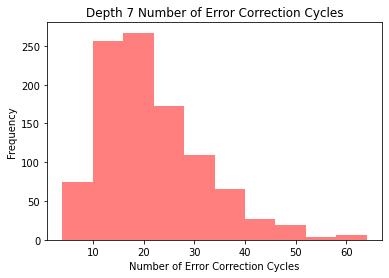

Mean: 21.244
Standard Deviation: 10.000323194777257


In [13]:
num_bins_7 = 10
plt.hist(d7_dist, num_bins_7, facecolor='r', alpha=.5)
plt.gca().set(title='Depth 7 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d7 = sum(d7_dist) / len(d7_dist)
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d7 = statistics.pstdev(d7_dist) 
print('Mean: ' + str(mean_d7))
print('Standard Deviation: ' + str(sd_d7))